<a href="https://colab.research.google.com/github/rezahamzeh69/abm-targeted-information-risk/blob/main/finaaaaaaaaaaaal3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================================
# Google Colab - Dataset + Full Simulation مطابق ساختار مقاله
# خروجی: فایل‌های CSV کامل (حالت اولیه + لاگ‌های زمانی + پیام‌ها + ریسک)
# ============================================================

import os, json, math
import numpy as np
import pandas as pd
import networkx as nx

# ---------------------------
# 0) پارامترهای سناریو (قابل تغییر)
# ---------------------------
SEED = 42

N_EMPLOYEES = 80     # تعداد کارکنان (سناریو)
K_SIGNALS  = 6       # تعداد سیگنال‌ها برای belief_{ij} (سناریو)
T          = 60      # افق زمانی شبیه‌سازی (سناریو)

# شبکه‌ها (سناریو)
P_FORMAL   = 0.05
P_INFORMAL = 0.08

# کوپلینگ بین‌لایه‌ای (ورود غیررسمی به رسمی و بالعکس)
GAMMA_INF_TO_FOR = 0.12
GAMMA_FOR_TO_INF = 0.06

# شوک بیرونی
SHOCK_STD  = 0.10

# مهاجم
ATTACK_CLASSES = ["high_centrality", "bridge_nodes", "quasi_random"]
ATTACK_BUDGET0 = 6
OBS_NOISE_STD  = 0.05
INJECTION_INTENSITY = 0.75  # شدت تزریق (سطح‌بالا/انتزاعی)

# پذیرش/آلودگی
MISINFO_SIGNAL_INDEX = 0
ACCEPT_THRESHOLD = 0.70

# دفاع پویا (آستانه فعال‌سازی)
DEFENSE_THRESHOLD = 0.62
DEF_TRAIN_RATE = 0.07               # افزایش مقاومت شناختی در هر فعال‌سازی
DEF_COMM_CONTROL_FACTOR = 0.85      # کاهش وزن یال‌های غیررسمی هنگام کنترل ارتباطات
DEF_TARGET_FRACTION = 0.12          # درصد گره‌های هدف آموزش

# تابع ریسک (فرم پایه و تعامل‌دار)
RISK_WEIGHTS_BASE = dict(contamination=0.30, decision_drop=0.35, structural=0.20, cognitive=0.15)
# فرم تعامل‌دار: یک سهم کوچک برای interaction و کاهش متناسب سایر وزن‌ها
RISK_WEIGHTS_INTER = dict(contamination=0.27, decision_drop=0.32, structural=0.19, cognitive=0.14, interaction=0.08)

# مدیر (پارامترهای شناختی/تصمیم)
MANAGER = dict(
    processing_capacity=40,
    selective_attention=0.55,
    ambiguity_tolerance=0.55,
    time_pressure_sensitivity=0.55,
    experience_level=12,
    wf=0.60,   # وزن‌دهی رسمی
    wi=0.40,   # وزن‌دهی غیررسمی
    theta0=0.55,
    lam=0.22,  # lambda
)

OUT_DIR = "/content/abm_risk_dataset"
os.makedirs(OUT_DIR, exist_ok=True)
rng = np.random.default_rng(SEED)

# ---------------------------
# Utils
# ---------------------------
def clip01(x): return np.clip(x, 0.0, 1.0)
def sigmoid(z): return 1.0 / (1.0 + np.exp(-z))

def beta(a, b, size=None):
    return rng.beta(a, b, size=size)

def randint(low, high, size=None):
    return rng.integers(low, high + 1, size=size)

# ---------------------------
# 1) ساخت شبکه‌ها (دو لایه)
# ---------------------------
def build_directed_gnp(n, p, w_low, w_high, w_name):
    G = nx.gnp_random_graph(n=n, p=p, seed=int(rng.integers(0, 1e9)), directed=True)
    for u, v in G.edges():
        G[u][v][w_name] = float(rng.uniform(w_low, w_high))
    return G

G_formal = build_directed_gnp(N_EMPLOYEES, P_FORMAL, 0.30, 1.00, "formal_weight")
G_inf    = build_directed_gnp(N_EMPLOYEES, P_INFORMAL, 0.05, 1.00, "trust_ij")

df_formal_edges0 = pd.DataFrame([(u, v, G_formal[u][v]["formal_weight"]) for u, v in G_formal.edges()],
                                columns=["src","dst","formal_weight"])
df_inf_edges0    = pd.DataFrame([(u, v, G_inf[u][v]["trust_ij"]) for u, v in G_inf.edges()],
                                columns=["src","dst","trust_ij"])

# برای شاخص‌های ساختاری (ترکیبی)
G_union = nx.DiGraph()
G_union.add_nodes_from(range(N_EMPLOYEES))
for u, v in G_formal.edges():
    G_union.add_edge(u, v, w=G_formal[u][v]["formal_weight"])
for u, v in G_inf.edges():
    if G_union.has_edge(u, v):
        G_union[u][v]["w"] = max(G_union[u][v]["w"], G_inf[u][v]["trust_ij"])
    else:
        G_union.add_edge(u, v, w=G_inf[u][v]["trust_ij"])

deg_cent = nx.degree_centrality(G_union)
bet_cent = nx.betweenness_centrality(G_union, normalized=True)
# bridge score (بین‌لایه‌ای/کوپلینگ): گره‌هایی که در هر دو لایه فعال‌اند
out_f = {i: G_formal.out_degree(i) for i in range(N_EMPLOYEES)}
out_i = {i: G_inf.out_degree(i) for i in range(N_EMPLOYEES)}
bridge_score = {i: (out_f[i] + 1) * (out_i[i] + 1) for i in range(N_EMPLOYEES)}
# نرمال‌سازی
bs_vals = np.array(list(bridge_score.values()), dtype=float)
bs_vals = (bs_vals - bs_vals.min()) / (bs_vals.max() - bs_vals.min() + 1e-9)
bridge_score = {i: float(bs_vals[i]) for i in range(N_EMPLOYEES)}

# ---------------------------
# 2) ساخت کارکنان (حالت اولیه)
# ---------------------------
employee_ids = np.arange(N_EMPLOYEES)

beliefs = beta(2.0, 2.0, size=(N_EMPLOYEES, K_SIGNALS))      # belief_{ij} ∈ [0,1]
uncertainty = beta(2.0, 2.0, size=N_EMPLOYEES)               # uncertainty_i ∈ [0,1]
conflict = np.var(beliefs, axis=1)                           # conflict_i = Var({belief_{ij}})

cognitive_resistance = beta(4.0, 2.0, size=N_EMPLOYEES)
confirmation_bias    = beta(2.0, 4.0, size=N_EMPLOYEES)
attention_capacity   = randint(6, 26, size=N_EMPLOYEES)
memory_decay         = beta(2.0, 6.0, size=N_EMPLOYEES)
risk_perception      = beta(2.0, 2.0, size=N_EMPLOYEES)

social_influence      = beta(2.0, 3.0, size=N_EMPLOYEES)
authority_sensitivity = beta(2.0, 3.0, size=N_EMPLOYEES)
share_threshold       = beta(2.0, 3.0, size=N_EMPLOYEES)
channel_preference    = rng.choice(["formal","informal"], size=N_EMPLOYEES, p=[0.5,0.5])

df_employees0 = pd.DataFrame({
    "employee_id": employee_ids,
    "uncertainty_i": clip01(uncertainty),
    "conflict_i": conflict,
    "cognitive_resistance_i": clip01(cognitive_resistance),
    "confirmation_bias_i": clip01(confirmation_bias),
    "attention_capacity_i": attention_capacity,
    "memory_decay_i": clip01(memory_decay),
    "risk_perception_i": clip01(risk_perception),
    "social_influence_i": clip01(social_influence),
    "authority_sensitivity_i": clip01(authority_sensitivity),
    "share_threshold_i": clip01(share_threshold),
    "channel_preference_i": channel_preference,
    "deg_centrality": [deg_cent[i] for i in range(N_EMPLOYEES)],
    "bet_centrality": [bet_cent[i] for i in range(N_EMPLOYEES)],
    "bridge_score":   [bridge_score[i] for i in range(N_EMPLOYEES)],
})
for j in range(K_SIGNALS):
    df_employees0[f"belief_{j}"] = beliefs[:, j]

# ---------------------------
# 3) مدیر + حالت اولیه
# ---------------------------
manager_state = dict(
    perceived_state=float(beta(2.0,2.0)),
    cognitive_load=0.0,
    uncertainty=float(beta(2.0,2.0)),
    stress_level=float(beta(2.0,2.0)),
)

df_manager0 = pd.DataFrame([{
    "manager_id": 0,
    **MANAGER,
    **{f"{k}_0": v for k, v in manager_state.items()}
}])

# ---------------------------
# 4) مهاجم + سیاست تطبیقی سطح‌بالا
# ---------------------------
attacker = dict(
    belief_about_network=float(beta(2.0,2.0)),
    belief_about_risk=float(beta(2.0,2.0)),
    uncertainty_attacker=float(beta(2.0,2.0)),
    learning_rate=float(rng.uniform(0.05, 0.35)),
    exploration_rate=float(rng.uniform(0.05, 0.35)),
    risk_appetite=float(beta(2.0,2.0)),
    patience=int(randint(4, 16)),
    budget=int(ATTACK_BUDGET0),
    observation_noise=float(OBS_NOISE_STD),
    injection_intensity=float(INJECTION_INTENSITY),
)
# احتمال انتخاب کلاس‌های هدف‌گیری
attack_probs = np.array([1.0/len(ATTACK_CLASSES)]*len(ATTACK_CLASSES), dtype=float)

df_attacker0 = pd.DataFrame([{
    "attacker_id": 0,
    **attacker,
    "targeting_classes": ",".join(ATTACK_CLASSES),
}])

# ---------------------------
# 5) دفاع (ایستا/پویا) + لاگ هزینه
# ---------------------------
defense = dict(
    general_training_level=0.0,
    targeted_training_level=0.0,
    communication_control_level=0.0,
    activation_threshold=float(DEFENSE_THRESHOLD),
    unit_cost_training=float(rng.uniform(0.5, 2.0)),
    unit_cost_comm_control=float(rng.uniform(0.5, 2.0)),
    defense_budget_total=float(rng.uniform(80, 220)),
    spent=0.0,
)
df_defense0 = pd.DataFrame([{"defense_id":0, **defense}])

# ---------------------------
# 6) شوک بیرونی + حالت حقیقت (تصمیم مرجع)
# ---------------------------
shocks = rng.normal(0.0, SHOCK_STD, size=T)

true_state = np.zeros(T)
x = 0.0
for t in range(T):
    # یک دینامیک ساده و انتزاعی برای "حالت واقعی محیط"
    x = 0.90*x + shocks[t] + rng.normal(0, 0.03)
    true_state[t] = clip01(0.5 + x)

theta_ref = 0.5
ref_decision = (true_state > theta_ref).astype(int)

df_shocks = pd.DataFrame({"t": np.arange(1, T+1), "external_shock_t": shocks, "true_state_t": true_state, "ref_decision_t": ref_decision})

# ---------------------------
# 7) شبیه‌سازی: پیام‌ها، باورها، تصمیم‌ها، ریسک، تطبیق مهاجم، دفاع پویا
# ---------------------------
# inbox برای هر کارمند: لیست پیام‌ها (val, channel, weight, src, is_attack)
inbox = [[] for _ in range(N_EMPLOYEES)]
prev_shared = np.zeros(N_EMPLOYEES, dtype=int)
prev_channel = np.array(["informal"]*N_EMPLOYEES, dtype=object)

# لاگ‌ها
employee_time_rows = []
message_rows = []
manager_rows = []
risk_rows = []
attacker_rows = []
defense_rows = []
network_rows = []

R_prev = 0.0

def pick_targets(strategy, budget):
    nodes = np.arange(N_EMPLOYEES)
    if strategy == "high_centrality":
        score = np.array([deg_cent[i] for i in nodes]) * 0.5 + np.array([bet_cent[i] for i in nodes]) * 0.5
        return nodes[np.argsort(-score)][:budget]
    if strategy == "bridge_nodes":
        score = np.array([bridge_score[i] for i in nodes])
        return nodes[np.argsort(-score)][:budget]
    # quasi_random
    return rng.choice(nodes, size=budget, replace=False)

def aggregate_inbox(i):
    """خلاصه مواجهه اطلاعاتی کارمند i (انتزاعی): خروجی 0..1 برای سیگنال بد (misinfo)"""
    if len(inbox[i]) == 0:
        return 0.0, 0, 0.0  # exposure, volume, conflict_in_msgs
    vals = np.array([m[0] for m in inbox[i]], dtype=float)
    wts  = np.array([m[2] for m in inbox[i]], dtype=float)
    wts = wts / (wts.sum() + 1e-9)
    mu = float(np.sum(vals * wts))
    conf = float(np.var(vals))  # تعارض سیگنال‌های دریافتی (انتزاعی)
    return mu, len(inbox[i]), conf

def compute_structural_vulnerability(contaminated_mask):
    """ویژگی توپولوژیک حساس به اینکه 'چه کسی' آلوده شده است."""
    if contaminated_mask.sum() == 0:
        return 0.0
    idx = np.where(contaminated_mask)[0]
    score = 0.5*np.mean([deg_cent[i] for i in idx]) + 0.3*np.mean([bet_cent[i] for i in idx]) + 0.2*np.mean([bridge_score[i] for i in idx])
    return float(clip01(score / (max(deg_cent.values()) + 1e-9))) if max(deg_cent.values())>0 else float(clip01(score))

def risk_function(components, mode="base"):
    """ریسک نرمال‌شده 0..1 : ترکیب وزن‌دار + (اختیاری) تعامل‌دار"""
    if mode == "base":
        w = RISK_WEIGHTS_BASE
        R = (w["contamination"]*components["contamination"] +
             w["decision_drop"]*components["decision_drop"] +
             w["structural"]*components["structural"] +
             w["cognitive"]*components["cognitive"])
        return float(clip01(R))
    else:
        w = RISK_WEIGHTS_INTER
        R = (w["contamination"]*components["contamination"] +
             w["decision_drop"]*components["decision_drop"] +
             w["structural"]*components["structural"] +
             w["cognitive"]*components["cognitive"] +
             w["interaction"]*components["interaction"])
        return float(clip01(R))

def defender_apply(contaminated_mask):
    """آموزش هدفمند + کنترل ارتباطات غیررسمی (انتزاعی و امن)"""
    nonlocal_cand = np.arange(N_EMPLOYEES)
    # گره‌های بحرانی: ترکیب ساختاری + آلودگی
    crit_score = (0.5*np.array([bet_cent[i] for i in nonlocal_cand]) +
                  0.3*np.array([bridge_score[i] for i in nonlocal_cand]) +
                  0.2*np.array([deg_cent[i] for i in nonlocal_cand]))
    if contaminated_mask.sum() > 0:
        crit_score = crit_score * (0.6 + 0.4*contaminated_mask.astype(float))

    k = max(1, int(DEF_TARGET_FRACTION*N_EMPLOYEES))
    targets = nonlocal_cand[np.argsort(-crit_score)][:k]
    return targets

# شبیه‌سازی
for t in range(1, T+1):

    # -----------------------
    # گام 1.1: مشاهده ناقص و تصمیم مهاجم (سطح‌بالا)
    # -----------------------
    R_hat = float(clip01(R_prev + rng.normal(0.0, attacker["observation_noise"])))
    # انتخاب استراتژی با اکتشاف
    if rng.random() < attacker["exploration_rate"]:
        strat_idx = int(rng.integers(0, len(ATTACK_CLASSES)))
    else:
        strat_idx = int(rng.choice(np.arange(len(ATTACK_CLASSES)), p=attack_probs))
    strategy = ATTACK_CLASSES[strat_idx]
    targets = pick_targets(strategy, attacker["budget"])

    # تزریق انتزاعی: پیام با مقدار بالا برای سیگنال misinfo
    for i in targets:
        inbox[i].append((attacker["injection_intensity"], "attack", 1.0, -1, 1))
        message_rows.append(dict(t=t, src=-1, dst=i, channel="attack", value=attacker["injection_intensity"], weight=1.0, is_attack=1))

    # -----------------------
    # گام 1.2: انتشار چندکاناله (از بازنشرهای قبلی)
    # -----------------------
    # هر کسی که در t-1 share کرده، به همسایه‌های خودش پیام می‌فرستد
    for src in range(N_EMPLOYEES):
        if prev_shared[src] == 0:
            continue
        ch = prev_channel[src]

        if ch == "formal":
            # رسمی
            for _, dst in G_formal.out_edges(src):
                w = G_formal[src][dst]["formal_weight"]
                val = float(beliefs[src, MISINFO_SIGNAL_INDEX])
                inbox[dst].append((val, "formal", w, src, 0))
                message_rows.append(dict(t=t, src=src, dst=dst, channel="formal", value=val, weight=w, is_attack=0))
            # کوپلینگ رسمی->غیررسمی
            if rng.random() < GAMMA_FOR_TO_INF:
                for _, dst in G_inf.out_edges(src):
                    w = G_inf[src][dst]["trust_ij"]
                    val = float(beliefs[src, MISINFO_SIGNAL_INDEX])
                    inbox[dst].append((val, "informal", w, src, 0))
                    message_rows.append(dict(t=t, src=src, dst=dst, channel="informal(coupled)", value=val, weight=w, is_attack=0))

        else:
            # غیررسمی
            for _, dst in G_inf.out_edges(src):
                w = G_inf[src][dst]["trust_ij"]
                val = float(beliefs[src, MISINFO_SIGNAL_INDEX])
                inbox[dst].append((val, "informal", w, src, 0))
                message_rows.append(dict(t=t, src=src, dst=dst, channel="informal", value=val, weight=w, is_attack=0))
            # کوپلینگ غیررسمی->رسمی
            if rng.random() < GAMMA_INF_TO_FOR:
                for _, dst in G_formal.out_edges(src):
                    w = G_formal[src][dst]["formal_weight"]
                    val = float(beliefs[src, MISINFO_SIGNAL_INDEX])
                    inbox[dst].append((val, "formal", w, src, 0))
                    message_rows.append(dict(t=t, src=src, dst=dst, channel="formal(coupled)", value=val, weight=w, is_attack=0))

    # شوک بیرونی به‌صورت یک پیام زمینه‌ای برای همه
    for i in range(N_EMPLOYEES):
        # شوک بیرونی را به [0,1] نگاشت می‌کنیم (انتزاعی)
        shock_val = float(clip01(0.5 + shocks[t-1]))
        inbox[i].append((shock_val, "external", 0.15, -2, 0))
        message_rows.append(dict(t=t, src=-2, dst=i, channel="external", value=shock_val, weight=0.15, is_attack=0))

    # -----------------------
    # گام 1.3: پردازش شناختی کارکنان (تعارض، بار، به‌روزرسانی باور، عدم‌قطعیت)
    # -----------------------
    emp_cog_load = np.zeros(N_EMPLOYEES, dtype=float)
    emp_msg_conf = np.zeros(N_EMPLOYEES, dtype=float)
    emp_volume   = np.zeros(N_EMPLOYEES, dtype=int)

    for i in range(N_EMPLOYEES):
        exposure, vol, msg_conf = aggregate_inbox(i)
        emp_volume[i] = vol
        emp_msg_conf[i] = msg_conf

        # بار شناختی: حجم / ظرفیت * (1 + تعارض پیام‌ها)
        load = (vol / (attention_capacity[i] + 1e-9)) * (1.0 + msg_conf)
        emp_cog_load[i] = float(clip01(load))

        # به‌روزرسانی belief سیگنال misinfo (انتزاعی ولی "شناختی-اجتماعی")
        b_old = float(beliefs[i, MISINFO_SIGNAL_INDEX])

        # همسویی با باور قبلی (برای confirmation bias)
        align = 1.0 - abs(exposure - b_old)  # 0..1
        alpha = (0.35 + 0.45*(1.0 - cognitive_resistance[i])) * (0.7 + 0.3*confirmation_bias[i]*align)
        alpha = alpha * (1.0 - 0.55*emp_cog_load[i])  # بار شناختی بالا -> یادگیری/به‌روزرسانی کندتر/آشفته‌تر
        alpha = float(clip01(alpha))

        # فراموشی/حافظه: بخشی از وزن قبلی کم می‌شود
        b_new = (1.0 - memory_decay[i]) * b_old + memory_decay[i] * ((1.0 - alpha)*b_old + alpha*exposure)
        beliefs[i, MISINFO_SIGNAL_INDEX] = float(clip01(b_new))

        # سیگنال‌های دیگر: برای ایجاد تعارض/چندبعدی‌بودن، کمی به سمت (1-exposure) حرکت می‌دهیم
        for j in range(K_SIGNALS):
            if j == MISINFO_SIGNAL_INDEX:
                continue
            bj = float(beliefs[i, j])
            beliefs[i, j] = float(clip01(0.92*bj + 0.08*(1.0-exposure)))

        # conflict_i = Var({belief_{ij}})
        conflict[i] = float(np.var(beliefs[i, :]))

        # افزایش عدم‌قطعیت: تابعی از conflict و load
        u_old = float(uncertainty[i])
        u_new = 0.85*u_old + 0.15*clip01(0.5*conflict[i] + 0.5*emp_cog_load[i])
        uncertainty[i] = float(clip01(u_new))

    # -----------------------
    # گام 1.4: تصمیم بازنشر کارکنان (ظرفیت توجه، انتخاب کانال، share)
    # -----------------------
    shared = np.zeros(N_EMPLOYEES, dtype=int)
    chosen_channel = np.array(["informal"]*N_EMPLOYEES, dtype=object)

    for i in range(N_EMPLOYEES):
        # اگر خیلی overload باشد یا پیام خیلی زیاد باشد، احتمال بازنشر کم می‌شود
        b = float(beliefs[i, MISINFO_SIGNAL_INDEX])
        th = float(share_threshold[i])

        # احتمال بازنشر: تابعی از belief، بار شناختی، ادراک ریسک و نفوذ اجتماعی
        z = 5.0*(b - th) - 2.2*emp_cog_load[i] + 0.6*social_influence[i] - 0.4*risk_perception[i]
        p_share = float(clip01(sigmoid(z)))

        # ظرفیت توجه: اگر تعداد پیام‌ها بیش از ظرفیت باشد، بازنشر محدودتر
        cap_factor = 1.0 if emp_volume[i] <= attention_capacity[i] else 0.65
        p_share *= cap_factor

        if rng.random() < p_share:
            shared[i] = 1
            # انتخاب کانال با توجه به ترجیح + حساسیت به اقتدار (رسمی‌بودن)
            if channel_preference[i] == "formal":
                chosen_channel[i] = "formal"
            else:
                chosen_channel[i] = "informal"
            # اثر authority_sensitivity: گرایش به رسمی‌کردن
            if rng.random() < float(authority_sensitivity[i]*0.30):
                chosen_channel[i] = "formal"

    # -----------------------
    # گام 1.5: تطبیق شبکه (تغییر وزن یال‌ها در غیررسمی)
    # -----------------------
    # انتزاع: اگر گیرنده به سمت belief بالاتر رفت، اعتماد به فرستنده کمی زیاد می‌شود وگرنه کم
    # برای سادگی: فقط یال‌های پیام‌های غیرحمله و غیر external را لحاظ می‌کنیم
    for row in message_rows[-(N_EMPLOYEES*10+attacker["budget"]+50):]:  # پنجره اخیر؛ بهینه‌سازی
        if row["t"] != t:
            continue
        if row["src"] < 0:
            continue
        if "informal" in row["channel"] and G_inf.has_edge(row["src"], row["dst"]):
            src, dst = int(row["src"]), int(row["dst"])
            w = float(G_inf[src][dst]["trust_ij"])
            # اگر باور گیرنده بالاتر از مقدار پیام باشد، یعنی "پذیرش" نسبی رخ داده
            delta = 0.015 if beliefs[dst, MISINFO_SIGNAL_INDEX] >= row["value"] else -0.015
            G_inf[src][dst]["trust_ij"] = float(clip01(w + delta))

    # -----------------------
    # گام 1.6: تجمیع اطلاعات برای مدیر (فیلتر، وزن‌دهی، حذف اضافی)
    # -----------------------
    # مدیر از پیام‌های رسمی/غیررسمی نمونه‌گیری می‌کند؛ ظرفیت پردازش محدود
    # معیار توجه: weight پیام * (1+authority_sensitivity فرستنده)
    formal_msgs = []
    informal_msgs = []
    for r in message_rows:
        if r["t"] != t:
            continue
        if r["src"] < 0:
            continue
        score = float(r["weight"]) * (1.0 + 0.5*authority_sensitivity[int(r["src"])])
        if "formal" in r["channel"]:
            formal_msgs.append((score, r["value"]))
        elif "informal" in r["channel"]:
            informal_msgs.append((score, r["value"]))

    # فیلتر بر اساس selective_attention و ظرفیت
    cap = int(MANAGER["processing_capacity"])
    # سهم رسمی/غیررسمی برای نمونه‌گیری
    cap_f = max(0, int(round(MANAGER["wf"] * cap)))
    cap_i = max(0, cap - cap_f)

    formal_msgs.sort(key=lambda x: -x[0])
    informal_msgs.sort(key=lambda x: -x[0])

    # selective_attention: فقط درصدی از بالاترین‌ها را می‌بیند
    keep_f = int(max(1, math.ceil(MANAGER["selective_attention"] * min(len(formal_msgs), cap_f)))) if len(formal_msgs)>0 else 0
    keep_i = int(max(1, math.ceil(MANAGER["selective_attention"] * min(len(informal_msgs), cap_i)))) if len(informal_msgs)>0 else 0

    formal_vals = np.array([v for _, v in formal_msgs[:keep_f]], dtype=float) if keep_f>0 else np.array([], dtype=float)
    informal_vals = np.array([v for _, v in informal_msgs[:keep_i]], dtype=float) if keep_i>0 else np.array([], dtype=float)

    # -----------------------
    # گام 1.7: بار شناختی مدیر = حجم × تعارض × فشار زمانی
    # -----------------------
    vol_ratio = clip01((len(formal_vals) + len(informal_vals)) / (cap + 1e-9))
    msg_var = float(np.var(np.concatenate([formal_vals, informal_vals])) if (len(formal_vals)+len(informal_vals))>1 else 0.0)
    time_pressure = 1.0 + MANAGER["time_pressure_sensitivity"] * (t / T)

    manager_state["cognitive_load"] = float(clip01(vol_ratio * (1.0 + msg_var) * (time_pressure/2.0)))
    # برداشت ذهنی: وزن‌دهی کانال‌ها
    mu_f = float(np.mean(formal_vals)) if len(formal_vals)>0 else manager_state["perceived_state"]
    mu_i = float(np.mean(informal_vals)) if len(informal_vals)>0 else manager_state["perceived_state"]
    manager_state["perceived_state"] = float(clip01(MANAGER["wf"]*mu_f + MANAGER["wi"]*mu_i))

    # uncertainty/stress مدیر (انتزاعی)
    manager_state["uncertainty"] = float(clip01(0.90*manager_state["uncertainty"] + 0.10*(msg_var + abs(shocks[t-1]))))
    manager_state["stress_level"] = float(clip01(0.85*manager_state["stress_level"] + 0.15*manager_state["cognitive_load"]))

    # -----------------------
    # گام 1.8: تصمیم مدیر (آستانه پویا)
    # -----------------------
    theta_t = float(MANAGER["theta0"] + MANAGER["lam"] * manager_state["cognitive_load"])
    decision_t = 1 if manager_state["perceived_state"] > theta_t else 0

    # -----------------------
    # گام 1.9: کیفیت تصمیم = تطابق با تصمیم مرجع
    # -----------------------
    dq = 1 if decision_t == int(ref_decision[t-1]) else 0
    decision_drop = 1.0 - dq

    # -----------------------
    # گام 1.10: ریسک تصمیم‌محور (چهار مؤلفه + تعامل)
    # -----------------------
    contaminated = beliefs[:, MISINFO_SIGNAL_INDEX] > ACCEPT_THRESHOLD
    contamination_level = float(np.mean(contaminated.astype(float)))
    structural_vuln = compute_structural_vulnerability(contaminated)
    cognitive_pressure = float(clip01(0.60*manager_state["cognitive_load"] + 0.40*np.mean(uncertainty)))
    interaction = float(clip01(contamination_level * decision_drop))

    comps = dict(
        contamination=contamination_level,
        decision_drop=decision_drop,
        structural=structural_vuln,
        cognitive=cognitive_pressure,
        interaction=interaction
    )

    R_base = risk_function(comps, mode="base")
    R_inter = risk_function(comps, mode="interaction")

    # -----------------------
    # گام 1.11: تطبیق مهاجم (تقویت استراتژی موفق / تضعیف ناموفق)
    # -----------------------
    # پاداش: افزایش ریسک تعامل‌دار نسبت به قبل
    reward = float(R_inter - R_prev)
    lr = attacker["learning_rate"]
    # آپدیت ساده روی logits
    logits = np.log(attack_probs + 1e-9)
    logits[strat_idx] += lr * reward
    # softmax
    logits -= logits.max()
    attack_probs = np.exp(logits)
    attack_probs = attack_probs / attack_probs.sum()

    # -----------------------
    # گام 1.12: دفاع پویا (آستانه‌محور)
    # -----------------------
    defense_activated = 0
    trained_targets = []
    comm_control_applied = 0

    if R_inter >= defense["activation_threshold"] and defense["spent"] < defense["defense_budget_total"]:
        defense_activated = 1

        # آموزش هدفمند: افزایش cognitive_resistance_i برای گره‌های بحرانی
        trained_targets = defender_apply(contaminated_mask=contaminated)
        cognitive_resistance[trained_targets] = clip01(cognitive_resistance[trained_targets] + DEF_TRAIN_RATE)
        defense["targeted_training_level"] = float(clip01(defense["targeted_training_level"] + 0.10))
        # هزینه
        train_cost = defense["unit_cost_training"] * len(trained_targets)
        defense["spent"] += train_cost

        # کنترل ارتباطات غیررسمی: کاهش وزن یال‌ها
        comm_control_applied = 1
        for u, v in G_inf.edges():
            G_inf[u][v]["trust_ij"] = float(clip01(G_inf[u][v]["trust_ij"] * DEF_COMM_CONTROL_FACTOR))
        defense["communication_control_level"] = float(clip01(defense["communication_control_level"] + 0.10))
        comm_cost = defense["unit_cost_comm_control"] * 5.0
        defense["spent"] += comm_cost

    # -----------------------
    # گام 1.13: ثبت خروجی‌ها
    # -----------------------
    # employee panel
    for i in range(N_EMPLOYEES):
        employee_time_rows.append(dict(
            t=t, employee_id=i,
            belief_misinfo=float(beliefs[i, MISINFO_SIGNAL_INDEX]),
            uncertainty_i=float(uncertainty[i]),
            conflict_i=float(conflict[i]),
            cognitive_load_i=float(emp_cog_load[i]),
            msg_conflict_i=float(emp_msg_conf[i]),
            msg_volume_i=int(emp_volume[i]),
            shared_i=int(shared[i]),
            chosen_channel_i=str(chosen_channel[i]),
            contaminated_i=int(contaminated[i]),
            cognitive_resistance_i=float(cognitive_resistance[i]),
        ))

    manager_rows.append(dict(
        t=t,
        perceived_state_t=float(manager_state["perceived_state"]),
        cognitive_load_t=float(manager_state["cognitive_load"]),
        uncertainty_t=float(manager_state["uncertainty"]),
        stress_level_t=float(manager_state["stress_level"]),
        theta_t=float(theta_t),
        decision_t=int(decision_t),
        ref_decision_t=int(ref_decision[t-1]),
        decision_quality_t=int(dq),
        formal_msgs_used=int(len(formal_vals)),
        informal_msgs_used=int(len(informal_vals)),
    ))

    risk_rows.append(dict(
        t=t,
        R_base=float(R_base),
        R_interaction=float(R_inter),
        contamination=float(contamination_level),
        decision_drop=float(decision_drop),
        structural=float(structural_vuln),
        cognitive=float(cognitive_pressure),
        interaction=float(interaction),
    ))

    attacker_rows.append(dict(
        t=t,
        R_hat=float(R_hat),
        chosen_class=str(strategy),
        budget=int(attacker["budget"]),
        targets=",".join(map(str, targets.tolist())),
        reward=float(reward),
        p_high_centrality=float(attack_probs[ATTACK_CLASSES.index("high_centrality")]),
        p_bridge_nodes=float(attack_probs[ATTACK_CLASSES.index("bridge_nodes")]),
        p_quasi_random=float(attack_probs[ATTACK_CLASSES.index("quasi_random")]),
    ))

    defense_rows.append(dict(
        t=t,
        activated=int(defense_activated),
        trained_targets=",".join(map(str, trained_targets)) if len(trained_targets)>0 else "",
        spent=float(defense["spent"]),
        targeted_training_level=float(defense["targeted_training_level"]),
        communication_control_level=float(defense["communication_control_level"]),
        comm_control_applied=int(comm_control_applied),
    ))

    # شبکه (خلاصه)
    avg_trust = float(np.mean([G_inf[u][v]["trust_ij"] for u, v in G_inf.edges()])) if G_inf.number_of_edges()>0 else 0.0
    avg_formal = float(np.mean([G_formal[u][v]["formal_weight"] for u, v in G_formal.edges()])) if G_formal.number_of_edges()>0 else 0.0
    network_rows.append(dict(t=t, avg_trust_informal=avg_trust, avg_weight_formal=avg_formal))

    # آماده‌سازی برای گام بعد
    prev_shared = shared.copy()
    prev_channel = chosen_channel.copy()
    # inbox را خالی می‌کنیم (تحویل همزمان در گام بعد)
    inbox = [[] for _ in range(N_EMPLOYEES)]
    R_prev = R_inter

# ---------------------------
# 8) ساخت دیتافریم‌ها و ذخیره
# ---------------------------
df_employee_time = pd.DataFrame(employee_time_rows)
df_messages = pd.DataFrame(message_rows)
df_manager_time = pd.DataFrame(manager_rows)
df_risk = pd.DataFrame(risk_rows)
df_attacker_time = pd.DataFrame(attacker_rows)
df_defense_time = pd.DataFrame(defense_rows)
df_network_time = pd.DataFrame(network_rows)

# خروجی‌های حالت اولیه
df_employees0.to_csv(f"{OUT_DIR}/employees_static.csv", index=False)
df_manager0.to_csv(f"{OUT_DIR}/manager_static.csv", index=False)
df_attacker0.to_csv(f"{OUT_DIR}/attacker_static.csv", index=False)
df_defense0.to_csv(f"{OUT_DIR}/defense_static.csv", index=False)
df_formal_edges0.to_csv(f"{OUT_DIR}/formal_edges_initial.csv", index=False)
df_inf_edges0.to_csv(f"{OUT_DIR}/informal_edges_initial.csv", index=False)
df_shocks.to_csv(f"{OUT_DIR}/external_truth_series.csv", index=False)

# خروجی‌های زمانی (دیتاست کامل برای تحلیل/یادگیری)
df_employee_time.to_csv(f"{OUT_DIR}/employees_time.csv", index=False)
df_messages.to_csv(f"{OUT_DIR}/message_log.csv", index=False)
df_manager_time.to_csv(f"{OUT_DIR}/manager_time.csv", index=False)
df_risk.to_csv(f"{OUT_DIR}/risk_time.csv", index=False)
df_attacker_time.to_csv(f"{OUT_DIR}/attacker_time.csv", index=False)
df_defense_time.to_csv(f"{OUT_DIR}/defense_time.csv", index=False)
df_network_time.to_csv(f"{OUT_DIR}/network_time.csv", index=False)

meta = dict(
    seed=SEED, N_EMPLOYEES=N_EMPLOYEES, K_SIGNALS=K_SIGNALS, T=T,
    P_FORMAL=P_FORMAL, P_INFORMAL=P_INFORMAL,
    accept_threshold=ACCEPT_THRESHOLD,
    manager=MANAGER,
    risk_weights_base=RISK_WEIGHTS_BASE,
    risk_weights_interaction=RISK_WEIGHTS_INTER,
    attack_classes=ATTACK_CLASSES,
    defense_threshold=DEFENSE_THRESHOLD
)
with open(f"{OUT_DIR}/meta.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

print("✅ Dataset + Simulation logs created at:", OUT_DIR)
print("Files:", sorted(os.listdir(OUT_DIR))[:30], "...")
print("risk_time head:\n", df_risk.head())


✅ Dataset + Simulation logs created at: /content/abm_risk_dataset
Files: ['attacker_static.csv', 'attacker_time.csv', 'defense_static.csv', 'defense_time.csv', 'employees_static.csv', 'employees_time.csv', 'external_truth_series.csv', 'formal_edges_initial.csv', 'informal_edges_initial.csv', 'manager_static.csv', 'manager_time.csv', 'message_log.csv', 'meta.json', 'network_time.csv', 'risk_time.csv'] ...
risk_time head:
    t    R_base  R_interaction  contamination  decision_drop  structural  \
0  1  0.199676       0.186271         0.2000            0.0    0.572010   
1  2  0.213574       0.199242         0.2000            0.0    0.572010   
2  3  0.196833       0.183930         0.1625            0.0    0.553131   
3  4  0.191997       0.179920         0.1250            0.0    0.591893   
4  5  0.189318       0.177780         0.1000            0.0    0.624794   

   cognitive  interaction  
0   0.168493          0.0  
1   0.261146          0.0  
2   0.249712          0.0  
3   0.240787

In [2]:
# ============================================================
# CODE 2 (SELF-CONTAINED): True Monte Carlo + Sensitivity
# Works even if ABMModel is NOT already defined
# ============================================================

import os, json, math
import numpy as np
import pandas as pd
import networkx as nx

# ---------------------------
# Paths
# ---------------------------
BASE_DIR = "/content/abm_risk_dataset"
MC_DIR = f"{BASE_DIR}/monte_carlo_runs_fixed"
os.makedirs(MC_DIR, exist_ok=True)

# ---------------------------
# Monte Carlo settings
# ---------------------------
N_RUNS = 30
CRITICAL_RISK_THRESHOLD = 0.70

ATTACK_INTENSITIES = [0.4, 0.6, 0.8]
DEFENSE_THRESHOLDS = [0.5, 0.6, 0.7]

# ---------------------------
# Load base meta if exists
# ---------------------------
meta_path = f"{BASE_DIR}/meta.json"
BASE_CFG = {}
if os.path.exists(meta_path):
    with open(meta_path, "r", encoding="utf-8") as f:
        BASE_CFG = json.load(f)

# Fallback defaults
def default_cfg():
    return dict(
        seed=42,
        N_EMPLOYEES=80,
        K_SIGNALS=6,
        T=60,
        P_FORMAL=0.05,
        P_INFORMAL=0.08,
        GAMMA_INF_TO_FOR=0.12,
        GAMMA_FOR_TO_INF=0.06,
        SHOCK_STD=0.10,

        ATTACK_BUDGET0=6,
        OBS_NOISE_STD=0.05,
        ACCEPT_THRESHOLD=0.70,
        MISINFO_SIGNAL_INDEX=0,
        ATTACK_CLASSES=["high_centrality","bridge_nodes","quasi_random"],
        INJECTION_INTENSITY=0.75,

        DEFENSE_THRESHOLD=0.62,
        DEF_TRAIN_RATE=0.07,
        DEF_COMM_CONTROL_FACTOR=0.85,
        DEF_TARGET_FRACTION=0.12,

        RISK_WEIGHTS_BASE=dict(contamination=0.30, decision_drop=0.35, structural=0.20, cognitive=0.15),
        RISK_WEIGHTS_INTER=dict(contamination=0.27, decision_drop=0.32, structural=0.19, cognitive=0.14, interaction=0.08),

        MANAGER=dict(
            processing_capacity=40,
            selective_attention=0.55,
            ambiguity_tolerance=0.55,
            time_pressure_sensitivity=0.55,
            experience_level=12,
            wf=0.60, wi=0.40,
            theta0=0.55, lam=0.22,
        ),
    )

CFG0 = default_cfg()
# merge meta into defaults (meta keys may be partial)
for k, v in BASE_CFG.items():
    CFG0[k] = v

# ---------------------------
# Helpers
# ---------------------------
def clip01(x): return np.clip(x, 0.0, 1.0)
def sigmoid(z): return 1.0/(1.0+np.exp(-z))
def softmax(x):
    x = np.asarray(x, dtype=float)
    x = x - np.max(x)
    ex = np.exp(x)
    return ex/(np.sum(ex)+1e-12)

# ---------------------------
# Define ABMModel if missing
# ---------------------------
if "ABMModel" not in globals():

    class ABMModel:
        def __init__(self, cfg):
            self.cfg = cfg
            self.rng = np.random.default_rng(int(cfg["seed"]))

            self.N = int(cfg["N_EMPLOYEES"])
            self.K = int(cfg["K_SIGNALS"])
            self.T = int(cfg["T"])

            self.P_FORMAL = float(cfg["P_FORMAL"])
            self.P_INFORMAL = float(cfg["P_INFORMAL"])
            self.GAMMA_INF_TO_FOR = float(cfg.get("GAMMA_INF_TO_FOR", 0.12))
            self.GAMMA_FOR_TO_INF = float(cfg.get("GAMMA_FOR_TO_INF", 0.06))
            self.SHOCK_STD = float(cfg.get("SHOCK_STD", 0.10))

            self.MISINFO = int(cfg.get("MISINFO_SIGNAL_INDEX", 0))
            self.ACCEPT_THRESHOLD = float(cfg.get("ACCEPT_THRESHOLD", 0.70))

            self.attack_budget = int(cfg.get("ATTACK_BUDGET0", 6))
            self.obs_noise = float(cfg.get("OBS_NOISE_STD", 0.05))
            self.injection_intensity = float(cfg.get("INJECTION_INTENSITY", 0.75))

            self.ATTACK_CLASSES = list(cfg.get("ATTACK_CLASSES", ["high_centrality","bridge_nodes","quasi_random"]))

            self.def_threshold = float(cfg.get("DEFENSE_THRESHOLD", 0.62))
            self.def_train_rate = float(cfg.get("DEF_TRAIN_RATE", 0.07))
            self.def_comm_factor = float(cfg.get("DEF_COMM_CONTROL_FACTOR", 0.85))
            self.def_target_frac = float(cfg.get("DEF_TARGET_FRACTION", 0.12))

            self.WB = dict(cfg.get("RISK_WEIGHTS_BASE", CFG0["RISK_WEIGHTS_BASE"]))
            self.WI = dict(cfg.get("RISK_WEIGHTS_INTER", CFG0["RISK_WEIGHTS_INTER"]))

            self.manager = dict(cfg.get("MANAGER", CFG0["MANAGER"]))

            self._init_state()

        def _build_directed_gnp(self, p, w_low, w_high, w_name):
            G = nx.gnp_random_graph(n=self.N, p=p, seed=int(self.rng.integers(0, 1e9)), directed=True)
            for u, v in G.edges():
                G[u][v][w_name] = float(self.rng.uniform(w_low, w_high))
            return G

        def _init_state(self):
            self.G_formal = self._build_directed_gnp(self.P_FORMAL, 0.30, 1.00, "formal_weight")
            self.G_inf    = self._build_directed_gnp(self.P_INFORMAL, 0.05, 1.00, "trust_ij")

            # Union for centralities
            U = nx.DiGraph()
            U.add_nodes_from(range(self.N))
            for u, v in self.G_formal.edges():
                U.add_edge(u, v, w=self.G_formal[u][v]["formal_weight"])
            for u, v in self.G_inf.edges():
                if U.has_edge(u, v):
                    U[u][v]["w"] = max(U[u][v]["w"], self.G_inf[u][v]["trust_ij"])
                else:
                    U.add_edge(u, v, w=self.G_inf[u][v]["trust_ij"])

            self.deg = nx.degree_centrality(U)
            self.bet = nx.betweenness_centrality(U, normalized=True)

            out_f = {i: self.G_formal.out_degree(i) for i in range(self.N)}
            out_i = {i: self.G_inf.out_degree(i) for i in range(self.N)}
            bs = np.array([(out_f[i]+1)*(out_i[i]+1) for i in range(self.N)], dtype=float)
            bs = (bs-bs.min())/(bs.max()-bs.min()+1e-12)
            self.bridge = {i: float(bs[i]) for i in range(self.N)}

            # employees
            self.beliefs = self.rng.beta(2.0, 2.0, size=(self.N, self.K))
            self.unc = self.rng.beta(2.0, 2.0, size=self.N)
            self.conflict = np.var(self.beliefs, axis=1)

            self.cog_res = self.rng.beta(4.0, 2.0, size=self.N)
            self.conf_bias = self.rng.beta(2.0, 4.0, size=self.N)
            self.att_cap = self.rng.integers(6, 27, size=self.N)
            self.mem_decay = self.rng.beta(2.0, 6.0, size=self.N)
            self.risk_perc = self.rng.beta(2.0, 2.0, size=self.N)
            self.soc_inf = self.rng.beta(2.0, 3.0, size=self.N)
            self.auth_sens = self.rng.beta(2.0, 3.0, size=self.N)
            self.share_th = self.rng.beta(2.0, 3.0, size=self.N)
            self.pref = self.rng.choice(["formal","informal"], size=self.N, p=[0.5,0.5])

            self.m_state = dict(
                perceived_state=float(self.rng.beta(2.0,2.0)),
                cognitive_load=0.0,
                uncertainty=float(self.rng.beta(2.0,2.0)),
                stress_level=float(self.rng.beta(2.0,2.0)),
            )

            self.attack_probs = np.ones(len(self.ATTACK_CLASSES), dtype=float)/len(self.ATTACK_CLASSES)
            self.att_lr = float(self.rng.uniform(0.05, 0.35))
            self.att_explore = float(self.rng.uniform(0.05, 0.35))

            self.shocks = self.rng.normal(0.0, self.SHOCK_STD, size=self.T)
            true_state = np.zeros(self.T)
            x = 0.0
            for t in range(self.T):
                x = 0.90*x + self.shocks[t] + self.rng.normal(0, 0.03)
                true_state[t] = clip01(0.5 + x)
            self.ref = (true_state > 0.5).astype(int)

            self.prev_shared = np.zeros(self.N, dtype=int)
            self.prev_channel = np.array(["informal"]*self.N, dtype=object)
            self.inbox = [[] for _ in range(self.N)]

        def pick_targets(self, strategy, budget):
            nodes = np.arange(self.N)
            if strategy == "high_centrality":
                score = 0.5*np.array([self.deg[i] for i in nodes]) + 0.5*np.array([self.bet[i] for i in nodes])
                return nodes[np.argsort(-score)][:budget]
            if strategy == "bridge_nodes":
                score = np.array([self.bridge[i] for i in nodes])
                return nodes[np.argsort(-score)][:budget]
            return self.rng.choice(nodes, size=budget, replace=False)

        def aggregate_inbox(self, i):
            if len(self.inbox[i]) == 0:
                return 0.0, 0, 0.0
            vals = np.array([m[0] for m in self.inbox[i]], dtype=float)
            wts  = np.array([m[2] for m in self.inbox[i]], dtype=float)
            wts = wts/(np.sum(wts)+1e-12)
            return float(np.sum(vals*wts)), len(vals), float(np.var(vals))

        def structural(self, contaminated):
            if contaminated.sum() == 0:
                return 0.0
            idx = np.where(contaminated)[0]
            s = 0.5*np.mean([self.deg[i] for i in idx]) + 0.3*np.mean([self.bet[i] for i in idx]) + 0.2*np.mean([self.bridge[i] for i in idx])
            return float(clip01(s))

        def risk(self, comps, mode="interaction"):
            if mode == "base":
                w = self.WB
                R = (w["contamination"]*comps["contamination"] +
                     w["decision_drop"]*comps["decision_drop"] +
                     w["structural"]*comps["structural"] +
                     w["cognitive"]*comps["cognitive"])
                return float(clip01(R))
            w = self.WI
            R = (w["contamination"]*comps["contamination"] +
                 w["decision_drop"]*comps["decision_drop"] +
                 w["structural"]*comps["structural"] +
                 w["cognitive"]*comps["cognitive"] +
                 w["interaction"]*comps["interaction"])
            return float(clip01(R))

        def step(self, t, R_prev):
            # attacker choose
            if self.rng.random() < self.att_explore:
                idx = int(self.rng.integers(0, len(self.ATTACK_CLASSES)))
            else:
                idx = int(self.rng.choice(np.arange(len(self.ATTACK_CLASSES)), p=self.attack_probs))
            strategy = self.ATTACK_CLASSES[idx]
            targets = self.pick_targets(strategy, self.attack_budget)
            for i in targets:
                self.inbox[i].append((self.injection_intensity, "attack", 1.0, -1, 1))

            # propagation from prev shares
            for src in range(self.N):
                if self.prev_shared[src] == 0:
                    continue
                ch = self.prev_channel[src]
                if ch == "formal":
                    for _, dst in self.G_formal.out_edges(src):
                        w = self.G_formal[src][dst]["formal_weight"]
                        self.inbox[dst].append((float(self.beliefs[src, self.MISINFO]), "formal", w, src, 0))
                    if self.rng.random() < self.GAMMA_FOR_TO_INF:
                        for _, dst in self.G_inf.out_edges(src):
                            w = self.G_inf[src][dst]["trust_ij"]
                            self.inbox[dst].append((float(self.beliefs[src, self.MISINFO]), "informal", w, src, 0))
                else:
                    for _, dst in self.G_inf.out_edges(src):
                        w = self.G_inf[src][dst]["trust_ij"]
                        self.inbox[dst].append((float(self.beliefs[src, self.MISINFO]), "informal", w, src, 0))
                    if self.rng.random() < self.GAMMA_INF_TO_FOR:
                        for _, dst in self.G_formal.out_edges(src):
                            w = self.G_formal[src][dst]["formal_weight"]
                            self.inbox[dst].append((float(self.beliefs[src, self.MISINFO]), "formal", w, src, 0))

            # external
            shock_val = float(clip01(0.5 + self.shocks[t-1]))
            for i in range(self.N):
                self.inbox[i].append((shock_val, "external", 0.15, -2, 0))

            # employees update
            emp_load = np.zeros(self.N)
            msg_vol = np.zeros(self.N, dtype=int)
            msg_conf = np.zeros(self.N)
            for i in range(self.N):
                exposure, vol, conf = self.aggregate_inbox(i)
                msg_vol[i] = vol
                msg_conf[i] = conf
                emp_load[i] = float(clip01((vol/(self.att_cap[i]+1e-12))*(1.0+conf)))

                b_old = float(self.beliefs[i, self.MISINFO])
                align = 1.0 - abs(exposure - b_old)
                alpha = (0.35 + 0.45*(1.0 - self.cog_res[i]))*(0.7 + 0.3*self.conf_bias[i]*align)
                alpha = float(clip01(alpha*(1.0 - 0.55*emp_load[i])))

                b_new = (1.0-self.mem_decay[i])*b_old + self.mem_decay[i]*((1.0-alpha)*b_old + alpha*exposure)
                self.beliefs[i, self.MISINFO] = float(clip01(b_new))
                self.conflict[i] = float(np.var(self.beliefs[i,:]))
                self.unc[i] = float(clip01(0.85*self.unc[i] + 0.15*clip01(0.5*self.conflict[i] + 0.5*emp_load[i])))

            # share
            shared = np.zeros(self.N, dtype=int)
            channel = np.array(["informal"]*self.N, dtype=object)
            for i in range(self.N):
                b = float(self.beliefs[i, self.MISINFO])
                th = float(self.share_th[i])
                z = 5.0*(b-th) - 2.2*emp_load[i] + 0.6*self.soc_inf[i] - 0.4*self.risk_perc[i]
                p = float(clip01(sigmoid(z)))
                if msg_vol[i] > self.att_cap[i]:
                    p *= 0.65
                if self.rng.random() < p:
                    shared[i] = 1
                    channel[i] = self.pref[i]
                    if self.rng.random() < float(self.auth_sens[i]*0.30):
                        channel[i] = "formal"

            # manager decision
            cap = int(self.manager["processing_capacity"])
            sharers = np.where(shared==1)[0]
            f_src = sharers[channel[sharers]=="formal"]
            i_src = sharers[channel[sharers]=="informal"]

            mu_f = float(np.mean(self.beliefs[f_src, self.MISINFO])) if len(f_src)>0 else self.m_state["perceived_state"]
            mu_i = float(np.mean(self.beliefs[i_src, self.MISINFO])) if len(i_src)>0 else self.m_state["perceived_state"]
            self.m_state["perceived_state"] = float(clip01(self.manager["wf"]*mu_f + self.manager["wi"]*mu_i))

            vol_ratio = float(clip01((len(f_src)+len(i_src))/(cap+1e-12)))
            msg_var = float(np.var(np.concatenate([
                self.beliefs[f_src, self.MISINFO] if len(f_src)>0 else np.array([]),
                self.beliefs[i_src, self.MISINFO] if len(i_src)>0 else np.array([])
            ])) if (len(f_src)+len(i_src))>1 else 0.0)
            time_pressure = 1.0 + self.manager["time_pressure_sensitivity"]*(t/self.T)
            self.m_state["cognitive_load"] = float(clip01(vol_ratio*(1.0+msg_var)*(time_pressure/2.0)))

            theta_t = float(self.manager["theta0"] + self.manager["lam"]*self.m_state["cognitive_load"])
            decision = 1 if self.m_state["perceived_state"] > theta_t else 0
            dq = 1 if decision == int(self.ref[t-1]) else 0
            decision_drop = 1.0 - dq

            contaminated = (self.beliefs[:, self.MISINFO] > self.ACCEPT_THRESHOLD)
            contamination = float(np.mean(contaminated.astype(float)))
            structural = float(self.structural(contaminated))
            cognitive = float(clip01(0.60*self.m_state["cognitive_load"] + 0.40*np.mean(self.unc)))
            interaction = float(clip01(contamination*decision_drop))

            comps = dict(contamination=contamination, decision_drop=decision_drop, structural=structural, cognitive=cognitive, interaction=interaction)
            R_int = self.risk(comps, mode="interaction")

            # attacker update
            reward = float(R_int - R_prev)
            logits = np.log(self.attack_probs + 1e-12)
            logits[idx] += self.att_lr * reward
            self.attack_probs = softmax(logits)

            self.prev_shared = shared
            self.prev_channel = channel
            self.inbox = [[] for _ in range(self.N)]

            return R_int

        def run(self):
            rows = []
            R_prev = 0.0
            for t in range(1, self.T+1):
                R = self.step(t, R_prev)
                rows.append({"t": t, "R_interaction": float(R)})
                R_prev = float(R)
            return pd.DataFrame(rows)

# ---------------------------
# True Monte Carlo + Sensitivity
# ---------------------------
def run_single_simulation(seed, attack_intensity, defense_threshold):
    cfg = dict(CFG0)
    cfg["seed"] = int(seed)
    cfg["INJECTION_INTENSITY"] = float(attack_intensity)
    cfg["DEFENSE_THRESHOLD"] = float(defense_threshold)
    model = ABMModel(cfg)
    return model.run()

all_results = []
run_id = 0

for ai in ATTACK_INTENSITIES:
    for dt in DEFENSE_THRESHOLDS:
        for r in range(N_RUNS):
            run_id += 1
            seed = 1000 + run_id

            df_risk = run_single_simulation(seed, ai, dt)

            mean_risk = float(df_risk["R_interaction"].mean())
            max_risk = float(df_risk["R_interaction"].max())
            cumulative_risk = float(df_risk["R_interaction"].sum())
            prob_critical = float(np.mean(df_risk["R_interaction"] >= CRITICAL_RISK_THRESHOLD))

            all_results.append(dict(
                run_id=run_id,
                attack_intensity=ai,
                defense_threshold=dt,
                mean_risk=mean_risk,
                max_risk=max_risk,
                cumulative_risk=cumulative_risk,
                prob_critical=prob_critical
            ))

df_runs = pd.DataFrame(all_results)
df_agg = df_runs.groupby(["attack_intensity","defense_threshold"]).agg(
    mean_risk=("mean_risk","mean"),
    std_risk=("mean_risk","std"),
    p05=("mean_risk", lambda x: float(np.quantile(x,0.05))),
    p50=("mean_risk", lambda x: float(np.quantile(x,0.50))),
    p95=("mean_risk", lambda x: float(np.quantile(x,0.95))),
    mean_max_risk=("max_risk","mean"),
    mean_cumulative_risk=("cumulative_risk","mean"),
    prob_critical=("prob_critical","mean"),
).reset_index()

df_runs.to_csv(f"{MC_DIR}/mc_all_runs_raw.csv", index=False)
df_agg.to_csv(f"{MC_DIR}/mc_aggregated_results.csv", index=False)

print("✅ TRUE Monte Carlo & Sensitivity Analysis completed (SELF-CONTAINED)")
print("📁 Results saved in:", MC_DIR)
display(df_agg)

✅ TRUE Monte Carlo & Sensitivity Analysis completed (SELF-CONTAINED)
📁 Results saved in: /content/abm_risk_dataset/monte_carlo_runs_fixed


,attack_intensity,defense_threshold,mean_risk,std_risk,p05,p50,p95,mean_max_risk,mean_cumulative_risk,prob_critical
0,0.4,0.5,0.247192,0.071253,0.142727,0.257404,0.335704,0.466559,14.831542,0.0
1,0.4,0.6,0.239073,0.075568,0.141005,0.235846,0.374745,0.466388,14.344374,0.0
2,0.4,0.7,0.255520,0.066645,0.159431,0.267243,0.354562,0.471156,15.331173,0.0
3,0.6,0.5,0.250835,0.069032,0.125150,0.257500,0.332734,0.485078,15.050077,0.0
4,0.6,0.6,0.257089,0.070142,0.136799,0.256329,0.360364,0.485409,15.425329,0.0
5,0.6,0.7,0.270246,0.059996,0.178195,0.271373,0.374612,0.479625,16.214776,0.0
6,0.8,0.5,0.290054,0.057192,0.211201,0.282352,0.386383,0.487505,17.403243,0.0
7,0.8,0.6,0.257575,0.071027,0.141806,0.259381,0.381650,0.481071,15.454505,0.0
8,0.8,0.7,0.259497,0.069660,0.169856,0.233140,0.359481,0.482775,15.569828,0.0


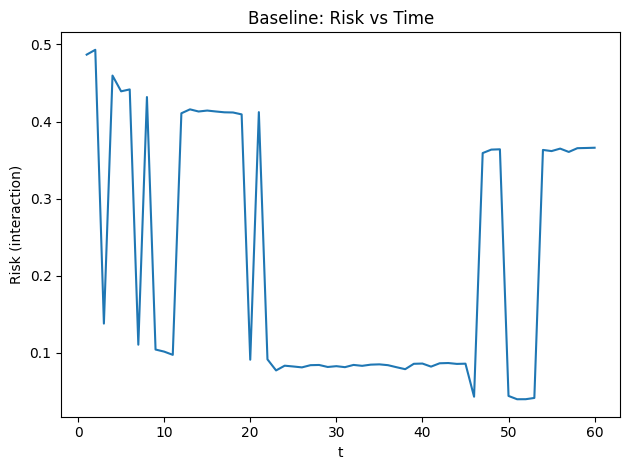

✅ Monte Carlo finished.
Aggregated (paper-ready) head:


,attack_intensity,defense_threshold,mean_risk,std_risk,p05,p50,p95,mean_max_risk,mean_cumulative_risk,prob_critical
0,0.4,0.5,0.226827,0.076719,0.101076,0.238407,0.323881,0.446593,13.609628,0.0
1,0.4,0.6,0.212971,0.070055,0.125213,0.205888,0.312399,0.444559,12.778283,0.0
2,0.4,0.7,0.213127,0.068977,0.098431,0.202057,0.305311,0.451137,12.787623,0.0
3,0.6,0.5,0.234089,0.077934,0.108962,0.253556,0.334835,0.458844,14.045313,0.0
4,0.6,0.6,0.237015,0.065506,0.152010,0.235032,0.326160,0.470238,14.220878,0.0


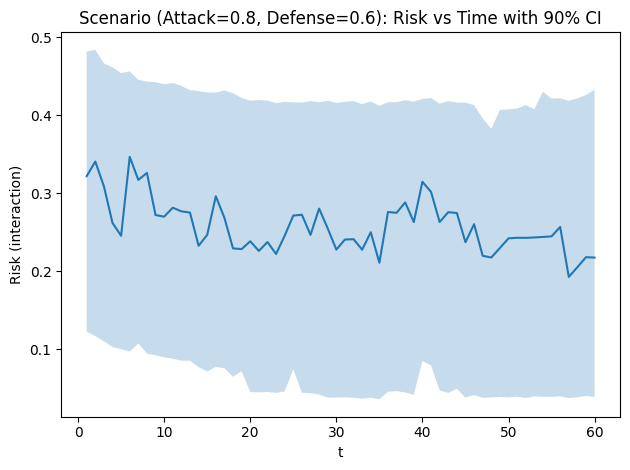

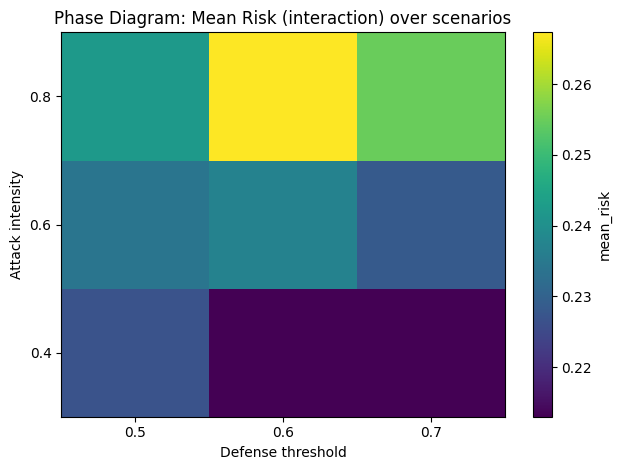

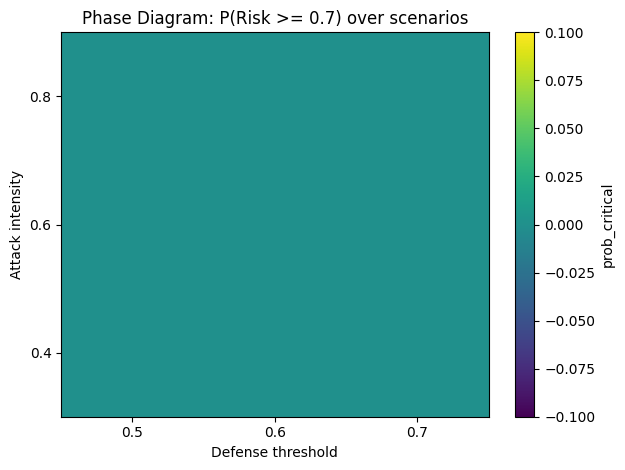

📁 All outputs saved in: /content/abm_risk_dataset/paper_outputs
Files: ['baseline_risk_time.csv', 'baseline_risk_vs_time.png', 'mc_aggregated_results.csv', 'mc_all_runs_summary.csv', 'phase_mean_risk.png', 'phase_prob_critical.png', 'scenario_risk_ci_ai0.8_dt0.6.png', 'scenario_timeseries_ai0.8_dt0.6.csv'] ...


In [3]:
# ============================================================
# PAPER-STYLE PLOTS + MODULAR (CLASS-BASED) VERSION
# Run this as ONE cell under your previous cells in Colab
# ============================================================

import os, json, math
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# ---------------------------
# Project paths (same project)
# ---------------------------
BASE_DIR = "/content/abm_risk_dataset"          # اگر کد قبلی اجرا شده باشد
OUT_DIR  = f"{BASE_DIR}/paper_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------------------------
# Defaults (اگر meta موجود باشد، از آن می‌خوانیم)
# ---------------------------
DEFAULTS = dict(
    seed=42,
    N_EMPLOYEES=80,
    K_SIGNALS=6,
    T=60,
    P_FORMAL=0.05,
    P_INFORMAL=0.08,
    GAMMA_INF_TO_FOR=0.12,
    GAMMA_FOR_TO_INF=0.06,
    SHOCK_STD=0.10,

    # attacker/defense
    ATTACK_BUDGET0=6,
    OBS_NOISE_STD=0.05,
    ACCEPT_THRESHOLD=0.70,
    MISINFO_SIGNAL_INDEX=0,
    ATTACK_CLASSES=["high_centrality","bridge_nodes","quasi_random"],

    INJECTION_INTENSITY=0.75,
    DEFENSE_THRESHOLD=0.62,
    DEF_TRAIN_RATE=0.07,
    DEF_COMM_CONTROL_FACTOR=0.85,
    DEF_TARGET_FRACTION=0.12,

    # risk weights
    RISK_WEIGHTS_BASE=dict(contamination=0.30, decision_drop=0.35, structural=0.20, cognitive=0.15),
    RISK_WEIGHTS_INTER=dict(contamination=0.27, decision_drop=0.32, structural=0.19, cognitive=0.14, interaction=0.08),

    # manager
    MANAGER=dict(
        processing_capacity=40,
        selective_attention=0.55,
        ambiguity_tolerance=0.55,
        time_pressure_sensitivity=0.55,
        experience_level=12,
        wf=0.60,
        wi=0.40,
        theta0=0.55,
        lam=0.22,
    )
)

meta_path = f"{BASE_DIR}/meta.json"
if os.path.exists(meta_path):
    try:
        with open(meta_path, "r", encoding="utf-8") as f:
            m = json.load(f)
        DEFAULTS["seed"] = m.get("seed", DEFAULTS["seed"])
        DEFAULTS["N_EMPLOYEES"] = m.get("N_EMPLOYEES", DEFAULTS["N_EMPLOYEES"])
        DEFAULTS["K_SIGNALS"] = m.get("K_SIGNALS", DEFAULTS["K_SIGNALS"])
        DEFAULTS["T"] = m.get("T", DEFAULTS["T"])
        DEFAULTS["P_FORMAL"] = m.get("P_FORMAL", DEFAULTS["P_FORMAL"])
        DEFAULTS["P_INFORMAL"] = m.get("P_INFORMAL", DEFAULTS["P_INFORMAL"])
        DEFAULTS["MANAGER"] = m.get("manager", DEFAULTS["MANAGER"])
        DEFAULTS["RISK_WEIGHTS_BASE"] = m.get("risk_weights_base", DEFAULTS["RISK_WEIGHTS_BASE"])
        DEFAULTS["RISK_WEIGHTS_INTER"] = m.get("risk_weights_interaction", DEFAULTS["RISK_WEIGHTS_INTER"])
    except Exception as e:
        print("⚠️ Could not read meta.json, using defaults. Error:", e)

# ---------------------------
# Helper funcs
# ---------------------------
def clip01(x): return np.clip(x, 0.0, 1.0)
def sigmoid(z): return 1.0/(1.0+np.exp(-z))
def beta(rng, a, b, size=None): return rng.beta(a, b, size=size)
def randint(rng, low, high, size=None): return rng.integers(low, high+1, size=size)

def softmax(x):
    x = np.asarray(x, dtype=float)
    x = x - np.max(x)
    ex = np.exp(x)
    return ex / (np.sum(ex) + 1e-12)

# ============================================================
# Modular (Class-based) ABM
# ============================================================
class ABMModel:
    def __init__(self, cfg: dict):
        self.cfg = cfg
        self.rng = np.random.default_rng(int(cfg["seed"]))

        self.N = int(cfg["N_EMPLOYEES"])
        self.K = int(cfg["K_SIGNALS"])
        self.T = int(cfg["T"])

        self.P_FORMAL = float(cfg["P_FORMAL"])
        self.P_INFORMAL = float(cfg["P_INFORMAL"])
        self.GAMMA_INF_TO_FOR = float(cfg["GAMMA_INF_TO_FOR"])
        self.GAMMA_FOR_TO_INF = float(cfg["GAMMA_FOR_TO_INF"])

        self.SHOCK_STD = float(cfg["SHOCK_STD"])
        self.MISINFO = int(cfg["MISINFO_SIGNAL_INDEX"])
        self.ACCEPT_THRESHOLD = float(cfg["ACCEPT_THRESHOLD"])

        self.ATTACK_CLASSES = list(cfg["ATTACK_CLASSES"])
        self.attack_budget0 = int(cfg["ATTACK_BUDGET0"])
        self.obs_noise = float(cfg["OBS_NOISE_STD"])
        self.injection_intensity = float(cfg["INJECTION_INTENSITY"])

        self.def_threshold = float(cfg["DEFENSE_THRESHOLD"])
        self.def_train_rate = float(cfg["DEF_TRAIN_RATE"])
        self.def_comm_factor = float(cfg["DEF_COMM_CONTROL_FACTOR"])
        self.def_target_frac = float(cfg["DEF_TARGET_FRACTION"])

        self.WB = dict(cfg["RISK_WEIGHTS_BASE"])
        self.WI = dict(cfg["RISK_WEIGHTS_INTER"])
        self.manager = dict(cfg["MANAGER"])

        self._init_state()

    def _build_directed_gnp(self, p, w_low, w_high, w_name):
        G = nx.gnp_random_graph(n=self.N, p=p, seed=int(self.rng.integers(0, 1e9)), directed=True)
        for u, v in G.edges():
            G[u][v][w_name] = float(self.rng.uniform(w_low, w_high))
        return G

    def _init_state(self):
        # Networks
        self.G_formal = self._build_directed_gnp(self.P_FORMAL, 0.30, 1.00, "formal_weight")
        self.G_inf    = self._build_directed_gnp(self.P_INFORMAL, 0.05, 1.00, "trust_ij")

        # Union graph for centralities
        G_union = nx.DiGraph()
        G_union.add_nodes_from(range(self.N))
        for u, v in self.G_formal.edges():
            G_union.add_edge(u, v, w=self.G_formal[u][v]["formal_weight"])
        for u, v in self.G_inf.edges():
            if G_union.has_edge(u, v):
                G_union[u][v]["w"] = max(G_union[u][v]["w"], self.G_inf[u][v]["trust_ij"])
            else:
                G_union.add_edge(u, v, w=self.G_inf[u][v]["trust_ij"])

        self.deg_cent = nx.degree_centrality(G_union)
        self.bet_cent = nx.betweenness_centrality(G_union, normalized=True)

        out_f = {i: self.G_formal.out_degree(i) for i in range(self.N)}
        out_i = {i: self.G_inf.out_degree(i) for i in range(self.N)}
        bs = np.array([(out_f[i]+1)*(out_i[i]+1) for i in range(self.N)], dtype=float)
        bs = (bs - bs.min())/(bs.max() - bs.min() + 1e-12)
        self.bridge = {i: float(bs[i]) for i in range(self.N)}

        # Employees
        self.beliefs = beta(self.rng, 2.0, 2.0, size=(self.N, self.K))
        self.uncertainty = beta(self.rng, 2.0, 2.0, size=self.N)
        self.conflict = np.var(self.beliefs, axis=1)

        self.cog_res = beta(self.rng, 4.0, 2.0, size=self.N)
        self.conf_bias = beta(self.rng, 2.0, 4.0, size=self.N)
        self.att_cap = randint(self.rng, 6, 26, size=self.N)
        self.mem_decay = beta(self.rng, 2.0, 6.0, size=self.N)
        self.risk_perc = beta(self.rng, 2.0, 2.0, size=self.N)
        self.soc_inf = beta(self.rng, 2.0, 3.0, size=self.N)
        self.auth_sens = beta(self.rng, 2.0, 3.0, size=self.N)
        self.share_th = beta(self.rng, 2.0, 3.0, size=self.N)
        self.pref = self.rng.choice(["formal","informal"], size=self.N, p=[0.5,0.5])

        # Manager state
        self.m_state = dict(
            perceived_state=float(beta(self.rng, 2.0,2.0)),
            cognitive_load=0.0,
            uncertainty=float(beta(self.rng, 2.0,2.0)),
            stress_level=float(beta(self.rng, 2.0,2.0)),
        )

        # Attacker policy
        self.attack_probs = np.ones(len(self.ATTACK_CLASSES), dtype=float) / len(self.ATTACK_CLASSES)
        self.att_lr = float(self.rng.uniform(0.05, 0.35))
        self.att_explore = float(self.rng.uniform(0.05, 0.35))

        # Defense (budget simplified)
        self.def_spent = 0.0
        self.def_budget = float(self.rng.uniform(80, 220))
        self.targeted_training_level = 0.0
        self.comm_control_level = 0.0

        # Shocks + truth
        self.shocks = self.rng.normal(0.0, self.SHOCK_STD, size=self.T)
        true_state = np.zeros(self.T)
        x = 0.0
        for t in range(self.T):
            x = 0.90*x + self.shocks[t] + self.rng.normal(0, 0.03)
            true_state[t] = clip01(0.5 + x)
        self.true_state = true_state
        self.ref_decision = (true_state > 0.5).astype(int)

        # previous step sharing
        self.prev_shared = np.zeros(self.N, dtype=int)
        self.prev_channel = np.array(["informal"]*self.N, dtype=object)

        # inbox
        self.inbox = [[] for _ in range(self.N)]

    def pick_targets(self, strategy, budget):
        nodes = np.arange(self.N)
        if strategy == "high_centrality":
            score = 0.5*np.array([self.deg_cent[i] for i in nodes]) + 0.5*np.array([self.bet_cent[i] for i in nodes])
            return nodes[np.argsort(-score)][:budget]
        if strategy == "bridge_nodes":
            score = np.array([self.bridge[i] for i in nodes])
            return nodes[np.argsort(-score)][:budget]
        return self.rng.choice(nodes, size=budget, replace=False)

    def aggregate_inbox(self, i):
        if len(self.inbox[i]) == 0:
            return 0.0, 0, 0.0
        vals = np.array([m[0] for m in self.inbox[i]], dtype=float)
        wts  = np.array([m[2] for m in self.inbox[i]], dtype=float)
        wts = wts/(np.sum(wts)+1e-12)
        mu = float(np.sum(vals*wts))
        conf = float(np.var(vals))
        return mu, len(self.inbox[i]), conf

    def structural_vulnerability(self, contaminated_mask):
        if contaminated_mask.sum() == 0:
            return 0.0
        idx = np.where(contaminated_mask)[0]
        score = 0.5*np.mean([self.deg_cent[i] for i in idx]) + 0.3*np.mean([self.bet_cent[i] for i in idx]) + 0.2*np.mean([self.bridge[i] for i in idx])
        return float(clip01(score))

    def risk(self, comps, mode="interaction"):
        if mode == "base":
            w = self.WB
            R = (w["contamination"]*comps["contamination"] +
                 w["decision_drop"]*comps["decision_drop"] +
                 w["structural"]*comps["structural"] +
                 w["cognitive"]*comps["cognitive"])
            return float(clip01(R))
        w = self.WI
        R = (w["contamination"]*comps["contamination"] +
             w["decision_drop"]*comps["decision_drop"] +
             w["structural"]*comps["structural"] +
             w["cognitive"]*comps["cognitive"] +
             w["interaction"]*comps["interaction"])
        return float(clip01(R))

    def defender_targets(self, contaminated_mask):
        nodes = np.arange(self.N)
        crit = (0.5*np.array([self.bet_cent[i] for i in nodes]) +
                0.3*np.array([self.bridge[i] for i in nodes]) +
                0.2*np.array([self.deg_cent[i] for i in nodes]))
        if contaminated_mask.sum() > 0:
            crit = crit*(0.6 + 0.4*contaminated_mask.astype(float))
        k = max(1, int(self.def_target_frac*self.N))
        return nodes[np.argsort(-crit)][:k]

    def step(self, t, R_prev):
        # --- 1.1 attacker partial observation + choose strategy + inject ---
        R_hat = float(clip01(R_prev + self.rng.normal(0.0, self.obs_noise)))
        if self.rng.random() < self.att_explore:
            idx = int(self.rng.integers(0, len(self.ATTACK_CLASSES)))
        else:
            idx = int(self.rng.choice(np.arange(len(self.ATTACK_CLASSES)), p=self.attack_probs))
        strategy = self.ATTACK_CLASSES[idx]
        targets = self.pick_targets(strategy, self.attack_budget0)

        for i in targets:
            self.inbox[i].append((self.injection_intensity, "attack", 1.0, -1, 1))

        # --- 1.2 multi-channel propagation from prev shares + external shock ---
        for src in range(self.N):
            if self.prev_shared[src] == 0:
                continue
            ch = self.prev_channel[src]
            if ch == "formal":
                for _, dst in self.G_formal.out_edges(src):
                    w = self.G_formal[src][dst]["formal_weight"]
                    val = float(self.beliefs[src, self.MISINFO])
                    self.inbox[dst].append((val, "formal", w, src, 0))
                if self.rng.random() < self.GAMMA_FOR_TO_INF:
                    for _, dst in self.G_inf.out_edges(src):
                        w = self.G_inf[src][dst]["trust_ij"]
                        val = float(self.beliefs[src, self.MISINFO])
                        self.inbox[dst].append((val, "informal", w, src, 0))
            else:
                for _, dst in self.G_inf.out_edges(src):
                    w = self.G_inf[src][dst]["trust_ij"]
                    val = float(self.beliefs[src, self.MISINFO])
                    self.inbox[dst].append((val, "informal", w, src, 0))
                if self.rng.random() < self.GAMMA_INF_TO_FOR:
                    for _, dst in self.G_formal.out_edges(src):
                        w = self.G_formal[src][dst]["formal_weight"]
                        val = float(self.beliefs[src, self.MISINFO])
                        self.inbox[dst].append((val, "formal", w, src, 0))

        shock_val = float(clip01(0.5 + self.shocks[t-1]))
        for i in range(self.N):
            self.inbox[i].append((shock_val, "external", 0.15, -2, 0))

        # --- 1.3 cognitive processing of employees ---
        emp_load = np.zeros(self.N, dtype=float)
        msg_conf = np.zeros(self.N, dtype=float)
        msg_vol  = np.zeros(self.N, dtype=int)

        for i in range(self.N):
            exposure, vol, conf = self.aggregate_inbox(i)
            msg_vol[i] = vol
            msg_conf[i] = conf
            load = (vol/(self.att_cap[i]+1e-12))*(1.0 + conf)
            emp_load[i] = float(clip01(load))

            b_old = float(self.beliefs[i, self.MISINFO])
            align = 1.0 - abs(exposure - b_old)
            alpha = (0.35 + 0.45*(1.0 - self.cog_res[i])) * (0.7 + 0.3*self.conf_bias[i]*align)
            alpha = alpha*(1.0 - 0.55*emp_load[i])
            alpha = float(clip01(alpha))

            b_new = (1.0 - self.mem_decay[i])*b_old + self.mem_decay[i]*((1.0-alpha)*b_old + alpha*exposure)
            self.beliefs[i, self.MISINFO] = float(clip01(b_new))

            for j in range(self.K):
                if j == self.MISINFO:
                    continue
                self.beliefs[i, j] = float(clip01(0.92*self.beliefs[i, j] + 0.08*(1.0-exposure)))

            self.conflict[i] = float(np.var(self.beliefs[i, :]))
            self.uncertainty[i] = float(clip01(0.85*self.uncertainty[i] + 0.15*clip01(0.5*self.conflict[i] + 0.5*emp_load[i])))

        # --- 1.4 employees share decision ---
        shared = np.zeros(self.N, dtype=int)
        channel = np.array(["informal"]*self.N, dtype=object)

        for i in range(self.N):
            b = float(self.beliefs[i, self.MISINFO])
            th = float(self.share_th[i])
            z = 5.0*(b - th) - 2.2*emp_load[i] + 0.6*self.soc_inf[i] - 0.4*self.risk_perc[i]
            p = float(clip01(sigmoid(z)))
            if msg_vol[i] > self.att_cap[i]:
                p *= 0.65
            if self.rng.random() < p:
                shared[i] = 1
                channel[i] = self.pref[i]
                if self.rng.random() < float(self.auth_sens[i]*0.30):
                    channel[i] = "formal"

        # --- 1.5 network adaptation (informal trust update small) ---
        # lightweight: update all informal edges a tiny bit based on global contamination
        contam_level = float(np.mean((self.beliefs[:, self.MISINFO] > self.ACCEPT_THRESHOLD).astype(float)))
        for u, v in self.G_inf.edges():
            w = self.G_inf[u][v]["trust_ij"]
            self.G_inf[u][v]["trust_ij"] = float(clip01(w + 0.002*(contam_level - 0.5)))

        # --- 1.6 manager aggregation ---
        cap = int(self.manager["processing_capacity"])
        cap_f = max(0, int(round(self.manager["wf"]*cap)))
        cap_i = max(0, cap - cap_f)

        # approximate: manager observes samples from sharers
        sharers = np.where(shared==1)[0]
        formal_sources = sharers[channel[sharers]=="formal"]
        inf_sources    = sharers[channel[sharers]=="informal"]

        # selective attention: observe top-k by authority sensitivity
        def pick_sources(srcs, k):
            if len(srcs)==0 or k<=0: return np.array([], dtype=int)
            score = self.auth_sens[srcs]
            idxs = np.argsort(-score)[:k]
            keep = int(max(1, math.ceil(self.manager["selective_attention"]*len(idxs)))) if len(idxs)>0 else 0
            return srcs[idxs[:keep]]

        f_obs = pick_sources(formal_sources, cap_f)
        i_obs = pick_sources(inf_sources, cap_i)

        mu_f = float(np.mean(self.beliefs[f_obs, self.MISINFO])) if len(f_obs)>0 else self.m_state["perceived_state"]
        mu_i = float(np.mean(self.beliefs[i_obs, self.MISINFO])) if len(i_obs)>0 else self.m_state["perceived_state"]

        self.m_state["perceived_state"] = float(clip01(self.manager["wf"]*mu_f + self.manager["wi"]*mu_i))

        # --- 1.7 manager cognitive load ---
        vol_ratio = float(clip01((len(f_obs)+len(i_obs))/(cap+1e-12)))
        msg_var = float(np.var(np.concatenate([
            self.beliefs[f_obs, self.MISINFO] if len(f_obs)>0 else np.array([]),
            self.beliefs[i_obs, self.MISINFO] if len(i_obs)>0 else np.array([])
        ])) if (len(f_obs)+len(i_obs))>1 else 0.0)

        time_pressure = 1.0 + self.manager["time_pressure_sensitivity"]*(t/self.T)
        self.m_state["cognitive_load"] = float(clip01(vol_ratio*(1.0+msg_var)*(time_pressure/2.0)))
        self.m_state["uncertainty"] = float(clip01(0.90*self.m_state["uncertainty"] + 0.10*(msg_var + abs(self.shocks[t-1]))))
        self.m_state["stress_level"] = float(clip01(0.85*self.m_state["stress_level"] + 0.15*self.m_state["cognitive_load"]))

        # --- 1.8 manager decision ---
        theta_t = float(self.manager["theta0"] + self.manager["lam"]*self.m_state["cognitive_load"])
        decision_t = 1 if self.m_state["perceived_state"] > theta_t else 0

        # --- 1.9 decision quality ---
        dq = 1 if decision_t == int(self.ref_decision[t-1]) else 0
        decision_drop = 1.0 - dq

        # --- 1.10 risk ---
        contaminated = (self.beliefs[:, self.MISINFO] > self.ACCEPT_THRESHOLD)
        contamination_level = float(np.mean(contaminated.astype(float)))
        structural = self.structural_vulnerability(contaminated)
        cognitive = float(clip01(0.60*self.m_state["cognitive_load"] + 0.40*np.mean(self.uncertainty)))
        interaction = float(clip01(contamination_level*decision_drop))

        comps = dict(
            contamination=contamination_level,
            decision_drop=decision_drop,
            structural=structural,
            cognitive=cognitive,
            interaction=interaction
        )

        R_base = self.risk(comps, mode="base")
        R_int  = self.risk(comps, mode="interaction")

        # --- 1.11 attacker adaptation (reward on delta risk) ---
        reward = float(R_int - R_prev)
        logits = np.log(self.attack_probs + 1e-12)
        logits[idx] += self.att_lr * reward
        self.attack_probs = softmax(logits)

        # --- 1.12 defense dynamic ---
        activated = 0
        if R_int >= self.def_threshold and self.def_spent < self.def_budget:
            activated = 1
            targets_train = self.defender_targets(contaminated)
            self.cog_res[targets_train] = clip01(self.cog_res[targets_train] + self.def_train_rate)
            self.targeted_training_level = float(clip01(self.targeted_training_level + 0.10))
            # comm control: scale informal weights
            for u, v in self.G_inf.edges():
                self.G_inf[u][v]["trust_ij"] = float(clip01(self.G_inf[u][v]["trust_ij"] * self.def_comm_factor))
            self.comm_control_level = float(clip01(self.comm_control_level + 0.10))

        # --- 1.13 logs + prepare next ---
        self.prev_shared = shared
        self.prev_channel = channel
        self.inbox = [[] for _ in range(self.N)]

        return dict(
            t=t,
            R_base=R_base,
            R_interaction=R_int,
            contamination=contamination_level,
            decision_drop=decision_drop,
            structural=structural,
            cognitive=cognitive,
            interaction=interaction,
            decision_t=decision_t,
            ref_decision_t=int(self.ref_decision[t-1]),
            decision_quality_t=int(dq),
            theta_t=theta_t,
            cognitive_load_t=float(self.m_state["cognitive_load"]),
            perceived_state_t=float(self.m_state["perceived_state"]),
            R_hat=R_hat,
            chosen_class=strategy,
            reward=reward,
            p0=float(self.attack_probs[0]),
        )

    def run(self, return_full=False):
        rows = []
        R_prev = 0.0
        for t in range(1, self.T+1):
            row = self.step(t, R_prev)
            rows.append(row)
            R_prev = float(row["R_interaction"])
        df = pd.DataFrame(rows)
        return df

# ============================================================
# Step 2: Monte Carlo + Sensitivity (paper-style)
# ============================================================
def monte_carlo_sensitivity(
    base_cfg,
    n_runs=30,
    attack_intensities=(0.4,0.6,0.8),
    defense_thresholds=(0.5,0.6,0.7),
    critical_threshold=0.70,
    save_dir=OUT_DIR
):
    os.makedirs(save_dir, exist_ok=True)
    all_runs = []
    run_id = 0

    for ai in attack_intensities:
        for dt in defense_thresholds:
            for r in range(n_runs):
                run_id += 1
                cfg = dict(base_cfg)
                cfg["seed"] = int(1000 + run_id)
                cfg["INJECTION_INTENSITY"] = float(ai)
                cfg["DEFENSE_THRESHOLD"] = float(dt)

                model = ABMModel(cfg)
                df_risk = model.run()

                mean_risk = float(df_risk["R_interaction"].mean())
                max_risk = float(df_risk["R_interaction"].max())
                cum_risk = float(df_risk["R_interaction"].sum())
                prob_critical = float(np.mean(df_risk["R_interaction"] >= critical_threshold))

                all_runs.append(dict(
                    run_id=run_id,
                    attack_intensity=ai,
                    defense_threshold=dt,
                    mean_risk=mean_risk,
                    max_risk=max_risk,
                    cumulative_risk=cum_risk,
                    prob_critical=prob_critical
                ))

    df_runs = pd.DataFrame(all_runs)
    df_runs.to_csv(f"{save_dir}/mc_all_runs_summary.csv", index=False)

    agg = df_runs.groupby(["attack_intensity","defense_threshold"]).agg(
        mean_risk=("mean_risk","mean"),
        std_risk=("mean_risk","std"),
        p05=("mean_risk", lambda x: float(np.quantile(x,0.05))),
        p50=("mean_risk", lambda x: float(np.quantile(x,0.50))),
        p95=("mean_risk", lambda x: float(np.quantile(x,0.95))),
        mean_max_risk=("max_risk","mean"),
        mean_cumulative_risk=("cumulative_risk","mean"),
        prob_critical=("prob_critical","mean")
    ).reset_index()

    agg.to_csv(f"{save_dir}/mc_aggregated_results.csv", index=False)
    return df_runs, agg

# ============================================================
# Step 3: Paper-style plots
# ============================================================
def plot_risk_time_with_ci(df_runs_long, T, title, save_path):
    """
    df_runs_long columns: run_id, t, R_interaction
    """
    # pivot: index t, columns run_id
    pivot = df_runs_long.pivot_table(index="t", columns="run_id", values="R_interaction")
    mean = pivot.mean(axis=1)
    lo = pivot.quantile(0.05, axis=1)
    hi = pivot.quantile(0.95, axis=1)

    fig = plt.figure()
    plt.plot(mean.index, mean.values)
    plt.fill_between(mean.index, lo.values, hi.values, alpha=0.25)
    plt.xlabel("t")
    plt.ylabel("Risk (interaction)")
    plt.title(title)
    plt.tight_layout()
    fig.savefig(save_path, dpi=200)
    plt.show()

def plot_phase_diagram(agg, value_col, title, save_path):
    """
    heatmap of value_col over attack_intensity x defense_threshold
    """
    xs = np.sort(agg["attack_intensity"].unique())
    ys = np.sort(agg["defense_threshold"].unique())
    grid = np.full((len(xs), len(ys)), np.nan, dtype=float)

    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            v = agg.loc[(agg["attack_intensity"]==x) & (agg["defense_threshold"]==y), value_col]
            if len(v)>0:
                grid[i, j] = float(v.iloc[0])

    fig = plt.figure()
    plt.imshow(grid, aspect="auto", origin="lower")
    plt.xticks(np.arange(len(ys)), [str(y) for y in ys])
    plt.yticks(np.arange(len(xs)), [str(x) for x in xs])
    plt.xlabel("Defense threshold")
    plt.ylabel("Attack intensity")
    plt.colorbar(label=value_col)
    plt.title(title)
    plt.tight_layout()
    fig.savefig(save_path, dpi=200)
    plt.show()

# ============================================================
# RUN: baseline + Monte Carlo + plots
# ============================================================

base_cfg = dict(DEFAULTS)

# 1) یک اجرای پایه (برای sanity + ذخیره)
baseline_model = ABMModel(base_cfg)
df_baseline = baseline_model.run()
df_baseline.to_csv(f"{OUT_DIR}/baseline_risk_time.csv", index=False)

# plot baseline risk vs time
fig = plt.figure()
plt.plot(df_baseline["t"], df_baseline["R_interaction"])
plt.xlabel("t")
plt.ylabel("Risk (interaction)")
plt.title("Baseline: Risk vs Time")
plt.tight_layout()
fig.savefig(f"{OUT_DIR}/baseline_risk_vs_time.png", dpi=200)
plt.show()

# 2) Monte Carlo + Sensitivity
N_RUNS = 25  # اگر کند بود، کمتر کن
ATTACK_INTENSITIES = [0.4, 0.6, 0.8]
DEFENSE_THRESHOLDS = [0.5, 0.6, 0.7]
CRITICAL = 0.70

df_runs, agg = monte_carlo_sensitivity(
    base_cfg=base_cfg,
    n_runs=N_RUNS,
    attack_intensities=ATTACK_INTENSITIES,
    defense_thresholds=DEFENSE_THRESHOLDS,
    critical_threshold=CRITICAL,
    save_dir=OUT_DIR
)

print("✅ Monte Carlo finished.")
print("Aggregated (paper-ready) head:")
display(agg.head())

# 3) Risk vs Time with CI (برای یک سناریو نمونه: شدت حمله=0.8 و دفاع=0.6)
# برای این کار باید اجراهای همان سناریو را دوباره تولید کنیم ولی با ذخیره مسیر زمانی هر run
# (اینجا سبک مقاله: مسیر زمانی + CI)

def run_timeseries_for_scenario(base_cfg, ai, dt, n_runs=30):
    rows = []
    for k in range(n_runs):
        cfg = dict(base_cfg)
        cfg["seed"] = int(9000 + 100*int(ai*10) + 10*int(dt*10) + k)
        cfg["INJECTION_INTENSITY"] = float(ai)
        cfg["DEFENSE_THRESHOLD"] = float(dt)
        m = ABMModel(cfg)
        df = m.run()
        df_small = df[["t","R_interaction"]].copy()
        df_small["run_id"] = k
        rows.append(df_small)
    return pd.concat(rows, ignore_index=True)

df_ts = run_timeseries_for_scenario(base_cfg, ai=0.8, dt=0.6, n_runs=min(30, N_RUNS))
df_ts.to_csv(f"{OUT_DIR}/scenario_timeseries_ai0.8_dt0.6.csv", index=False)

plot_risk_time_with_ci(
    df_runs_long=df_ts,
    T=int(base_cfg["T"]),
    title="Scenario (Attack=0.8, Defense=0.6): Risk vs Time with 90% CI",
    save_path=f"{OUT_DIR}/scenario_risk_ci_ai0.8_dt0.6.png"
)

# 4) Phase diagram (mean_risk و prob_critical)
plot_phase_diagram(
    agg=agg,
    value_col="mean_risk",
    title="Phase Diagram: Mean Risk (interaction) over scenarios",
    save_path=f"{OUT_DIR}/phase_mean_risk.png"
)

plot_phase_diagram(
    agg=agg,
    value_col="prob_critical",
    title=f"Phase Diagram: P(Risk >= {CRITICAL}) over scenarios",
    save_path=f"{OUT_DIR}/phase_prob_critical.png"
)

print("📁 All outputs saved in:", OUT_DIR)
print("Files:", sorted(os.listdir(OUT_DIR))[:40], "...")


In [4]:
# ============================================================
# CODE 4 (UPGRADED SAFE): Extract from DOCX + Run MC
# MUST use existing full ABMModel; if missing -> clear error
# NO overwrite: saves to unique timestamp folder
# ============================================================

import os, re, json, time
import numpy as np
import pandas as pd

# ---------------------------
# HARD REQUIREMENT: ABMModel must exist
# ---------------------------
if "ABMModel" not in globals():
    raise RuntimeError(
        "❌ ABMModel is not defined in this notebook.\n\n"
        "✅ Fix:\n"
        "1) Run the cell that defines the FULL ABMModel (your Code 3 / modular model cell).\n"
        "2) Then re-run this Code 4 cell.\n\n"
        "Reason: This upgraded Code 4 is designed to avoid ambiguity and will NOT create a minimal fallback model."
    )

# ---------------------------
# Paths
# ---------------------------
BASE_DIR = "/content/abm_risk_dataset"
PAPER_DIR = f"{BASE_DIR}/paper_outputs"
os.makedirs(PAPER_DIR, exist_ok=True)

run_stamp = time.strftime("%Y%m%d_%H%M%S")
RUN_DIR = f"{PAPER_DIR}/extracted_run_{run_stamp}"
os.makedirs(RUN_DIR, exist_ok=True)

DOCS = [
    "/mnt/data/etc.docx",
    "/mnt/data/مدلسازی کمی ریسک حملات اطلاعاتی هدفمند بر تصمیم‌گیری سازمانی با استفاده از شبیه‌سازی عامل‌بنیاد.docx"
]

# ---------------------------
# Ensure python-docx installed
# ---------------------------
try:
    from docx import Document
except Exception:
    import subprocess, sys
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", "python-docx"])
    from docx import Document

def read_docx_text(path):
    if not os.path.exists(path):
        return ""
    doc = Document(path)
    parts = []
    for p in doc.paragraphs:
        if p.text and p.text.strip():
            parts.append(p.text.strip())
    return "\n".join(parts)

full_text = "\n\n".join([read_docx_text(p) for p in DOCS])

# ---------------------------
# Defaults (safe scientific defaults)
# ---------------------------
CFG = dict(
    seed=42,
    N_EMPLOYEES=80,
    K_SIGNALS=6,
    T=60,
    P_FORMAL=0.05,
    P_INFORMAL=0.08,
    GAMMA_INF_TO_FOR=0.12,
    GAMMA_FOR_TO_INF=0.06,
    SHOCK_STD=0.10,

    ATTACK_BUDGET0=6,
    OBS_NOISE_STD=0.05,
    ACCEPT_THRESHOLD=0.70,
    MISINFO_SIGNAL_INDEX=0,
    ATTACK_CLASSES=["high_centrality","bridge_nodes","quasi_random"],
    INJECTION_INTENSITY=0.75,

    DEFENSE_THRESHOLD=0.62,
    DEF_TRAIN_RATE=0.07,
    DEF_COMM_CONTROL_FACTOR=0.85,
    DEF_TARGET_FRACTION=0.12,

    RISK_WEIGHTS_BASE=dict(contamination=0.30, decision_drop=0.35, structural=0.20, cognitive=0.15),
    RISK_WEIGHTS_INTER=dict(contamination=0.27, decision_drop=0.32, structural=0.19, cognitive=0.14, interaction=0.08),

    MANAGER=dict(
        processing_capacity=40,
        selective_attention=0.55,
        ambiguity_tolerance=0.55,
        time_pressure_sensitivity=0.55,
        experience_level=12,
        wf=0.60, wi=0.40,
        theta0=0.55, lam=0.22,
    ),

    # Monte Carlo defaults
    N_RUNS=25,
    ATTACK_INTENSITIES=[0.4, 0.6, 0.8],
    DEFENSE_THRESHOLDS=[0.5, 0.6, 0.7],
    CRITICAL_RISK_THRESHOLD=0.70,
)

# If meta.json exists, merge it (only safe keys)
meta_path = f"{BASE_DIR}/meta.json"
if os.path.exists(meta_path):
    with open(meta_path, "r", encoding="utf-8") as f:
        meta = json.load(f)
    for k in ["seed","N_EMPLOYEES","K_SIGNALS","T","P_FORMAL","P_INFORMAL","SHOCK_STD"]:
        if k in meta:
            CFG[k] = meta[k]

# ---------------------------
# Regex extractors
# ---------------------------
def find_int(patterns, text):
    for pat in patterns:
        m = re.search(pat, text, flags=re.IGNORECASE)
        if m:
            try: return int(float(m.group(1)))
            except: pass
    return None

def find_float(patterns, text):
    for pat in patterns:
        m = re.search(pat, text, flags=re.IGNORECASE)
        if m:
            try: return float(m.group(1))
            except: pass
    return None

# Extract if numbers are explicitly present in files
N_val = find_int([r"\bN\s*=\s*([0-9]+)", r"تعداد\s+کارکنان\s*[:=]\s*([0-9]+)"], full_text)
T_val = find_int([r"\bT\s*=\s*([0-9]+)", r"افق\s+زمانی\s*[:=]\s*([0-9]+)"], full_text)
k_val = find_int([r"\bk\s*=\s*([0-9]+)", r"تعداد\s+سیگنال\s*[:=]\s*([0-9]+)"], full_text)

p_formal = find_float([r"P_FORMAL\s*=\s*([0-9]*\.?[0-9]+)", r"احتمال.*رسمی\s*[:=]\s*([0-9]*\.?[0-9]+)"], full_text)
p_informal = find_float([r"P_INFORMAL\s*=\s*([0-9]*\.?[0-9]+)", r"احتمال.*غیررسمی\s*[:=]\s*([0-9]*\.?[0-9]+)"], full_text)

attack_budget = find_int([r"budget_t\s*[:=]\s*([0-9]+)", r"بودجه\s+هدف‌گیری\s*[:=]\s*([0-9]+)"], full_text)
obs_noise = find_float([r"observation_noise\s*[:=]\s*([0-9]*\.?[0-9]+)", r"نویز\s+مشاهده\s*[:=]\s*([0-9]*\.?[0-9]+)"], full_text)
inj_intensity = find_float([r"injection_intensity\s*[:=]\s*([0-9]*\.?[0-9]+)", r"شدت\s+تزریق\s*[:=]\s*([0-9]*\.?[0-9]+)"], full_text)
def_thr = find_float([r"activation_threshold\s*[:=]\s*([0-9]*\.?[0-9]+)", r"آستانه\s+فعال‌سازی\s*[:=]\s*([0-9]*\.?[0-9]+)"], full_text)
mc_runs = find_int([r"N_RUNS\s*=\s*([0-9]+)", r"تعداد\s+تکرار.*مونت.*کارلو\s*[:=]\s*([0-9]+)"], full_text)

# Apply extracted values if found
if N_val is not None: CFG["N_EMPLOYEES"] = N_val
if T_val is not None: CFG["T"] = T_val
if k_val is not None: CFG["K_SIGNALS"] = k_val
if p_formal is not None: CFG["P_FORMAL"] = p_formal
if p_informal is not None: CFG["P_INFORMAL"] = p_informal
if attack_budget is not None: CFG["ATTACK_BUDGET0"] = attack_budget
if obs_noise is not None: CFG["OBS_NOISE_STD"] = obs_noise
if inj_intensity is not None: CFG["INJECTION_INTENSITY"] = inj_intensity
if def_thr is not None: CFG["DEFENSE_THRESHOLD"] = def_thr
if mc_runs is not None: CFG["N_RUNS"] = mc_runs

# Save resolved config (unique folder)
with open(f"{RUN_DIR}/extracted_config.json", "w", encoding="utf-8") as f:
    json.dump(CFG, f, ensure_ascii=False, indent=2)

print("✅ Resolved config saved to:", f"{RUN_DIR}/extracted_config.json")
print({k: CFG[k] for k in ["N_EMPLOYEES","K_SIGNALS","T","P_FORMAL","P_INFORMAL","ATTACK_BUDGET0","OBS_NOISE_STD","INJECTION_INTENSITY","DEFENSE_THRESHOLD","N_RUNS"]})

# ---------------------------
# Monte Carlo + Sensitivity using FULL ABMModel
# ---------------------------
N_RUNS = int(CFG["N_RUNS"])
AIs = list(CFG["ATTACK_INTENSITIES"])
DTs = list(CFG["DEFENSE_THRESHOLDS"])
CRITICAL = float(CFG["CRITICAL_RISK_THRESHOLD"])

all_rows = []
run_id = 0

for ai in AIs:
    for dt in DTs:
        for r in range(N_RUNS):
            run_id += 1
            cfg = dict(CFG)
            cfg["seed"] = int(1000 + run_id)
            cfg["INJECTION_INTENSITY"] = float(ai)
            cfg["DEFENSE_THRESHOLD"] = float(dt)

            model = ABMModel(cfg)
            df = model.run()  # must return DataFrame with R_interaction

            if "R_interaction" not in df.columns:
                raise RuntimeError(
                    "ABMModel.run() output does not contain column 'R_interaction'. "
                    "Please ensure your full ABMModel returns a risk time series DataFrame."
                )

            mean_risk = float(df["R_interaction"].mean())
            max_risk = float(df["R_interaction"].max())
            cum_risk = float(df["R_interaction"].sum())
            prob_crit = float(np.mean(df["R_interaction"] >= CRITICAL))

            all_rows.append(dict(
                run_id=run_id,
                attack_intensity=ai,
                defense_threshold=dt,
                mean_risk=mean_risk,
                max_risk=max_risk,
                cumulative_risk=cum_risk,
                prob_critical=prob_crit
            ))

df_runs = pd.DataFrame(all_rows)
df_agg = df_runs.groupby(["attack_intensity","defense_threshold"]).agg(
    mean_risk=("mean_risk","mean"),
    std_risk=("mean_risk","std"),
    p05=("mean_risk", lambda x: float(np.quantile(x,0.05))),
    p50=("mean_risk", lambda x: float(np.quantile(x,0.50))),
    p95=("mean_risk", lambda x: float(np.quantile(x,0.95))),
    mean_max_risk=("max_risk","mean"),
    mean_cumulative_risk=("cumulative_risk","mean"),
    prob_critical=("prob_critical","mean")
).reset_index()

df_runs.to_csv(f"{RUN_DIR}/mc_all_runs_summary.csv", index=False)
df_agg.to_csv(f"{RUN_DIR}/mc_aggregated_results.csv", index=False)

print("✅ SAFE Extract + MC (FULL ABMModel) completed.")
print("📁 Run directory:", RUN_DIR)
print("Files:", sorted(os.listdir(RUN_DIR)))
display(df_agg)


✅ Resolved config saved to: /content/abm_risk_dataset/paper_outputs/extracted_run_20251215_154620/extracted_config.json
{'N_EMPLOYEES': 80, 'K_SIGNALS': 6, 'T': 60, 'P_FORMAL': 0.05, 'P_INFORMAL': 0.08, 'ATTACK_BUDGET0': 6, 'OBS_NOISE_STD': 0.05, 'INJECTION_INTENSITY': 0.75, 'DEFENSE_THRESHOLD': 0.62, 'N_RUNS': 25}
✅ SAFE Extract + MC (FULL ABMModel) completed.
📁 Run directory: /content/abm_risk_dataset/paper_outputs/extracted_run_20251215_154620
Files: ['extracted_config.json', 'mc_aggregated_results.csv', 'mc_all_runs_summary.csv']


,attack_intensity,defense_threshold,mean_risk,std_risk,p05,p50,p95,mean_max_risk,mean_cumulative_risk,prob_critical
0,0.4,0.5,0.226827,0.076719,0.101076,0.238407,0.323881,0.446593,13.609628,0.0
1,0.4,0.6,0.212971,0.070055,0.125213,0.205888,0.312399,0.444559,12.778283,0.0
2,0.4,0.7,0.213127,0.068977,0.098431,0.202057,0.305311,0.451137,12.787623,0.0
3,0.6,0.5,0.234089,0.077934,0.108962,0.253556,0.334835,0.458844,14.045313,0.0
4,0.6,0.6,0.237015,0.065506,0.152010,0.235032,0.326160,0.470238,14.220878,0.0
5,0.6,0.7,0.228378,0.067211,0.109017,0.235209,0.329619,0.464686,13.702703,0.0
6,0.8,0.5,0.242069,0.059375,0.156090,0.238901,0.346729,0.466274,14.524166,0.0
7,0.8,0.6,0.267344,0.064570,0.179975,0.263984,0.373637,0.468725,16.040614,0.0
8,0.8,0.7,0.254961,0.071695,0.130192,0.243369,0.348396,0.458468,15.297682,0.0
